In [1]:
import os
import numpy as np
import torch

from PIL import Image

import torch.nn.functional as F

from kornia.filters import gaussian_blur2d
from kornia.filters.kernels import get_gaussian_kernel1d, get_gaussian_kernel2d

from kornia_sift import MyScalePyramid
import kornia.utils as KU
from img_utils import show_torch


def rotate_experiment_scale_pyr(file_path, rotations_90_deg, scale_p, compensate_gauss, compensate_interpolation):

    scale_p.rotate90_gauss = 0    
    scale_p.rotate90_interpolation = 0    
    
    img_np_o = np.array(Image.open(file_path))
    img_t_o = KU.image_to_tensor(img_np_o.copy(), False).float() / 255.

    scale_pyr = scale_p(img_t_o)[0]
    fl = scale_p.get_first_level(img_t_o)[0]

    img_t_r = torch.rot90(img_t_o, rotations_90_deg, [2, 3])
    
    if compensate_gauss:
            scale_p.rotate90_gauss = 4 - rotations_90_deg    
    if compensate_interpolation:
            scale_p.rotate90_interpolation = 4 - rotations_90_deg    
    
    scale_pyr_r = scale_p(img_t_r)[0]
    scale_pyr_r = [torch.rot90(scale_p, k=4 - rotations_90_deg, dims=(3, 4)) for scale_p in scale_pyr_r]

    return scale_pyr, scale_pyr_r            

            
def rotate_experiment_loop_pyr(img_to_show, scale_pyr, compensate_gauss, compensate_interpolation):

    img_dir = "demo_imgs/hypersim"
    files = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][:img_to_show]
    
    m = {}
    
    for file_path in files:
        values = []
        for rots in range(1, 2):
            sp, sp_r = rotate_experiment_scale_pyr(file_path, rots, scale_pyr, compensate_gauss, compensate_interpolation)
            values.append([sp, sp_r])
        m[file_path.split("/")[-1]] = values
            
    return m
            


scale_pyr: interpolation=nearest, compensate_gauss: False, compensate_interpolation: False


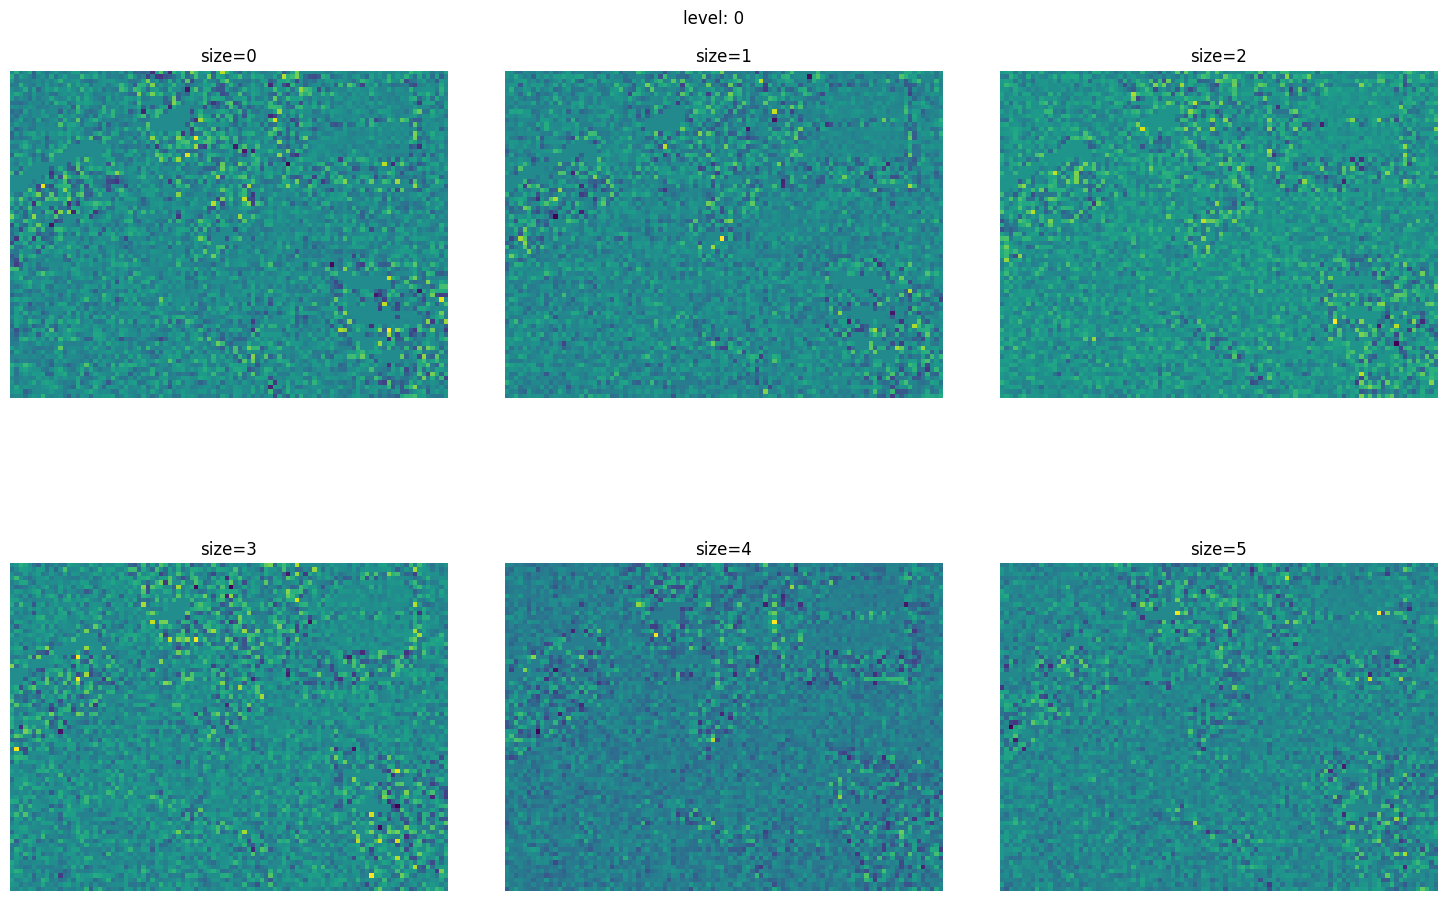

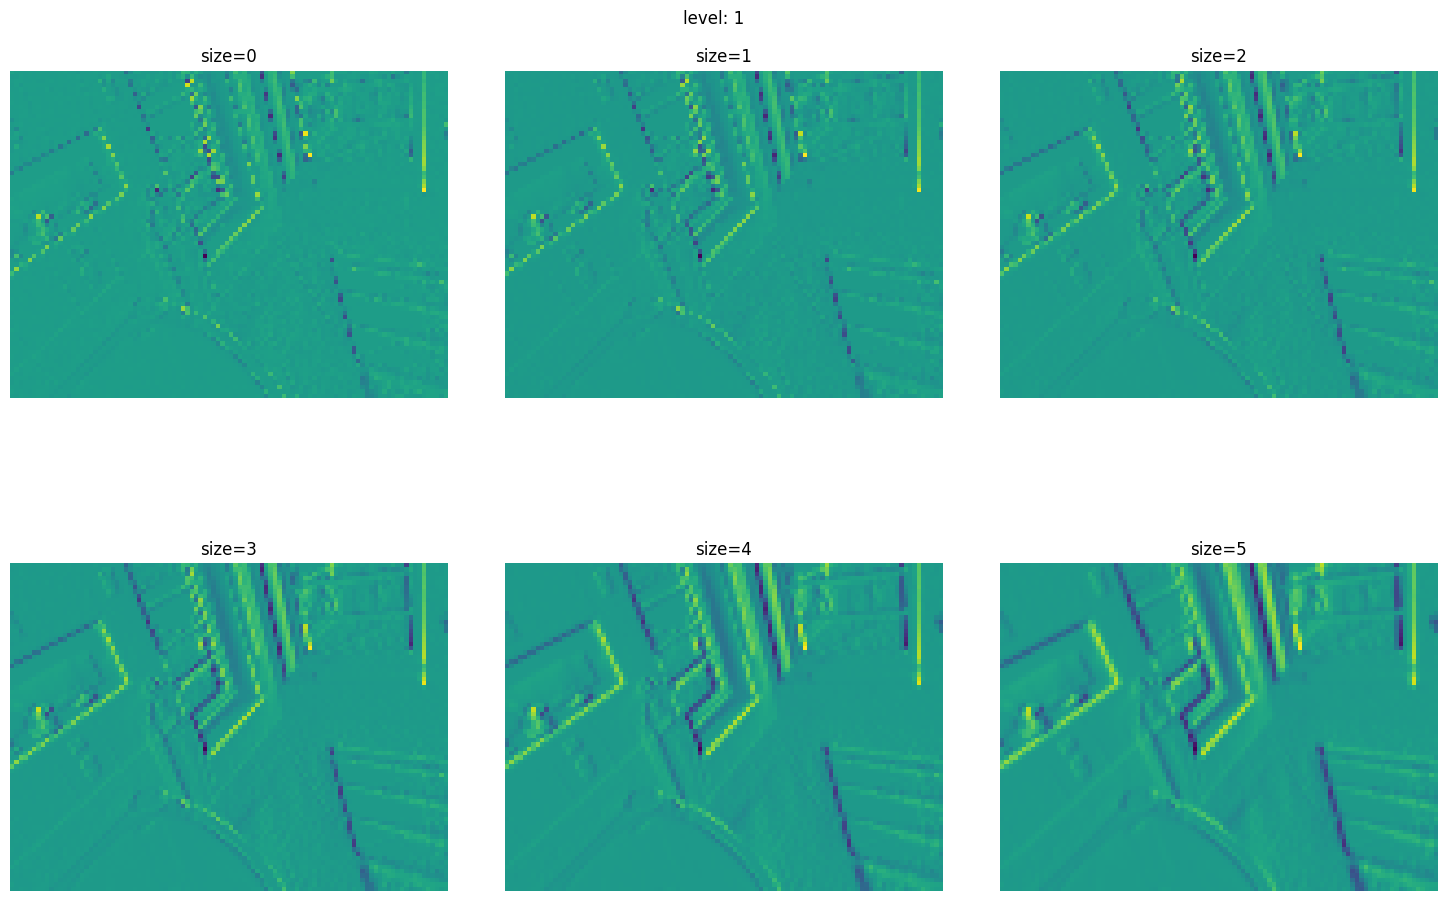

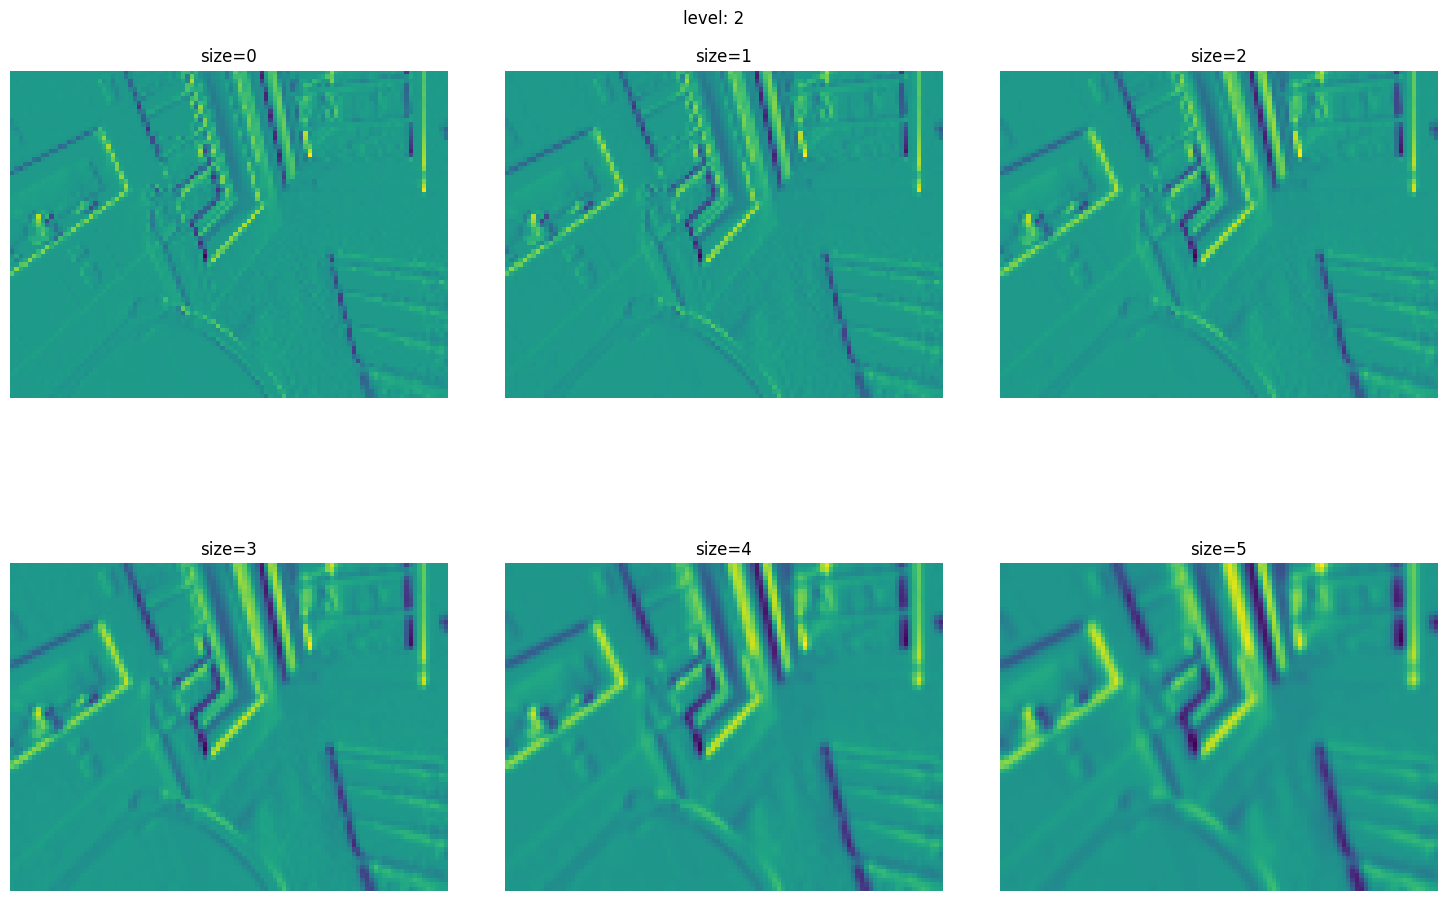

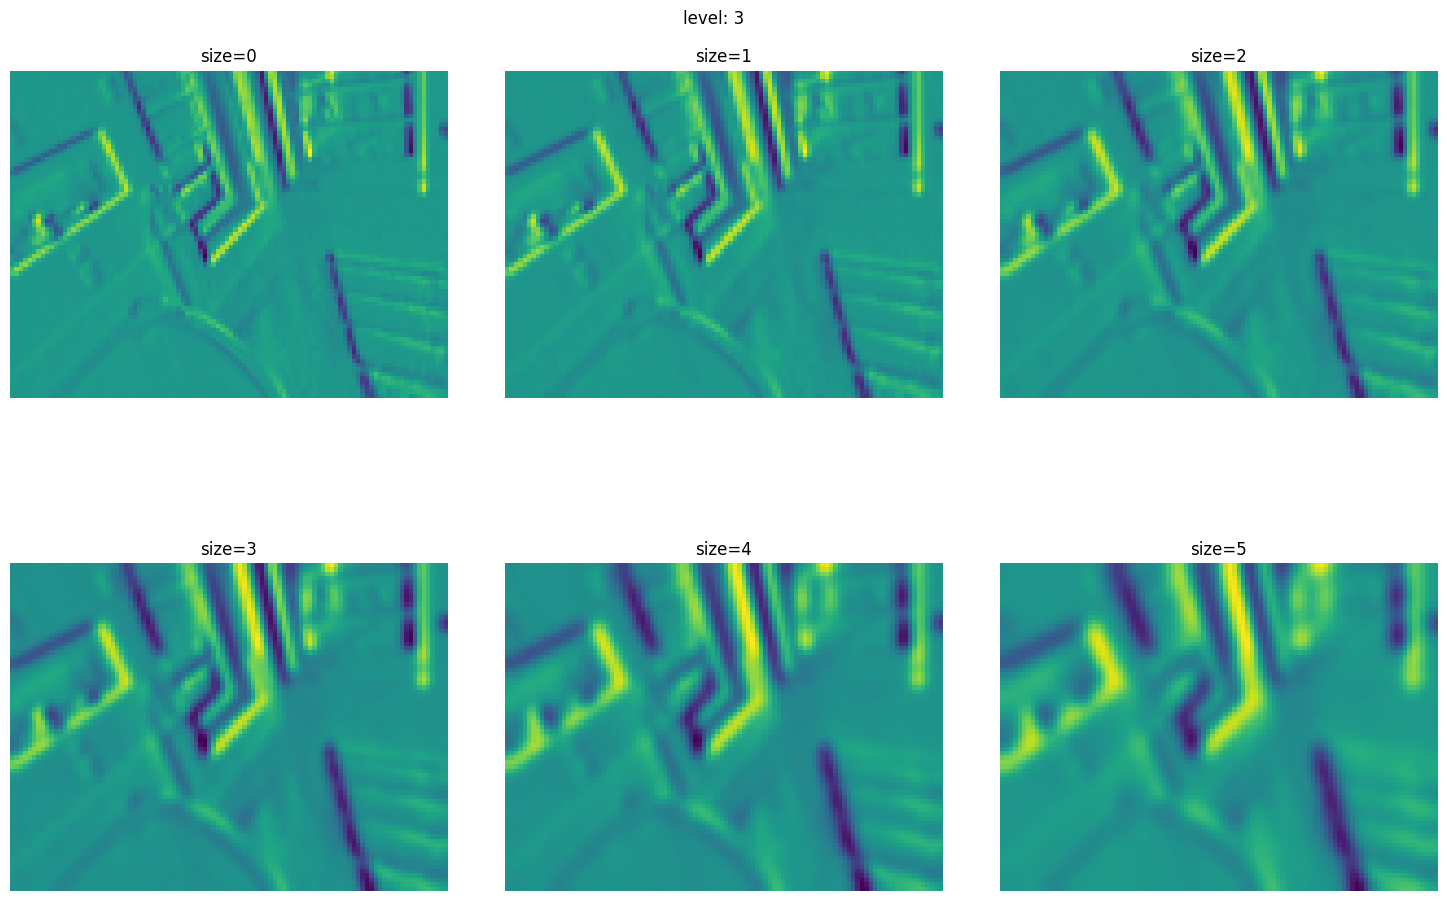

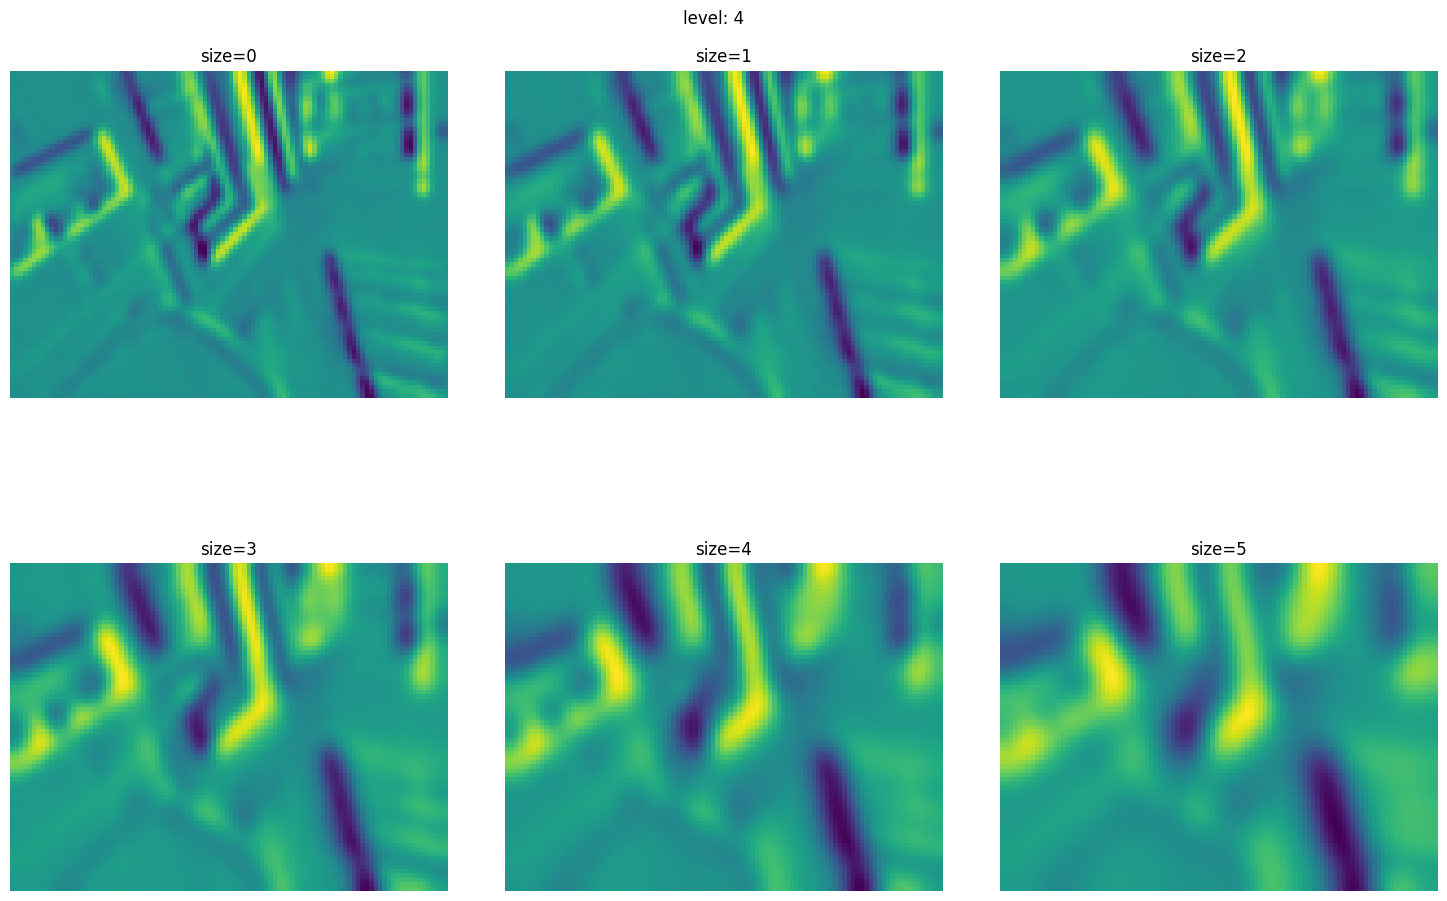

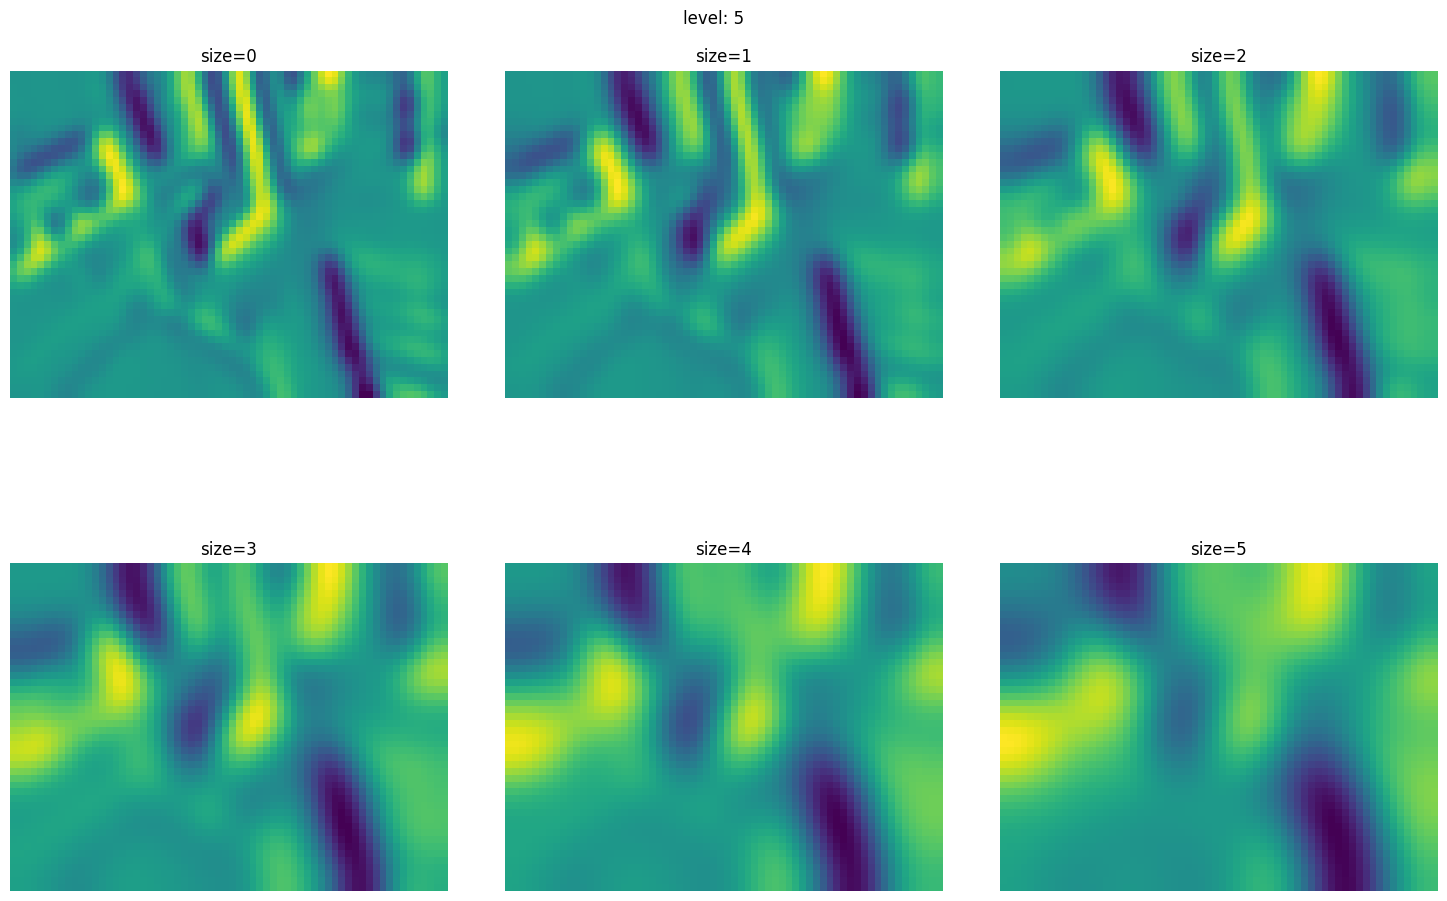

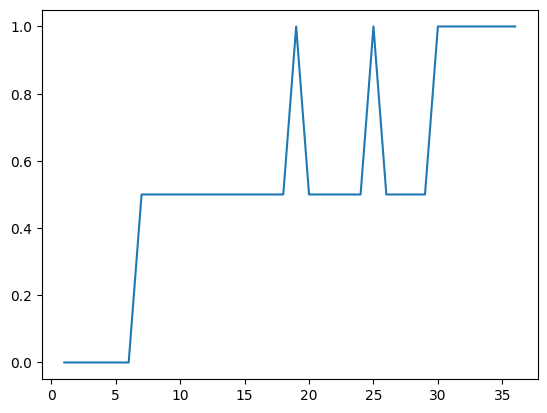

scale_pyr: interpolation=nearest, compensate_gauss: True, compensate_interpolation: False


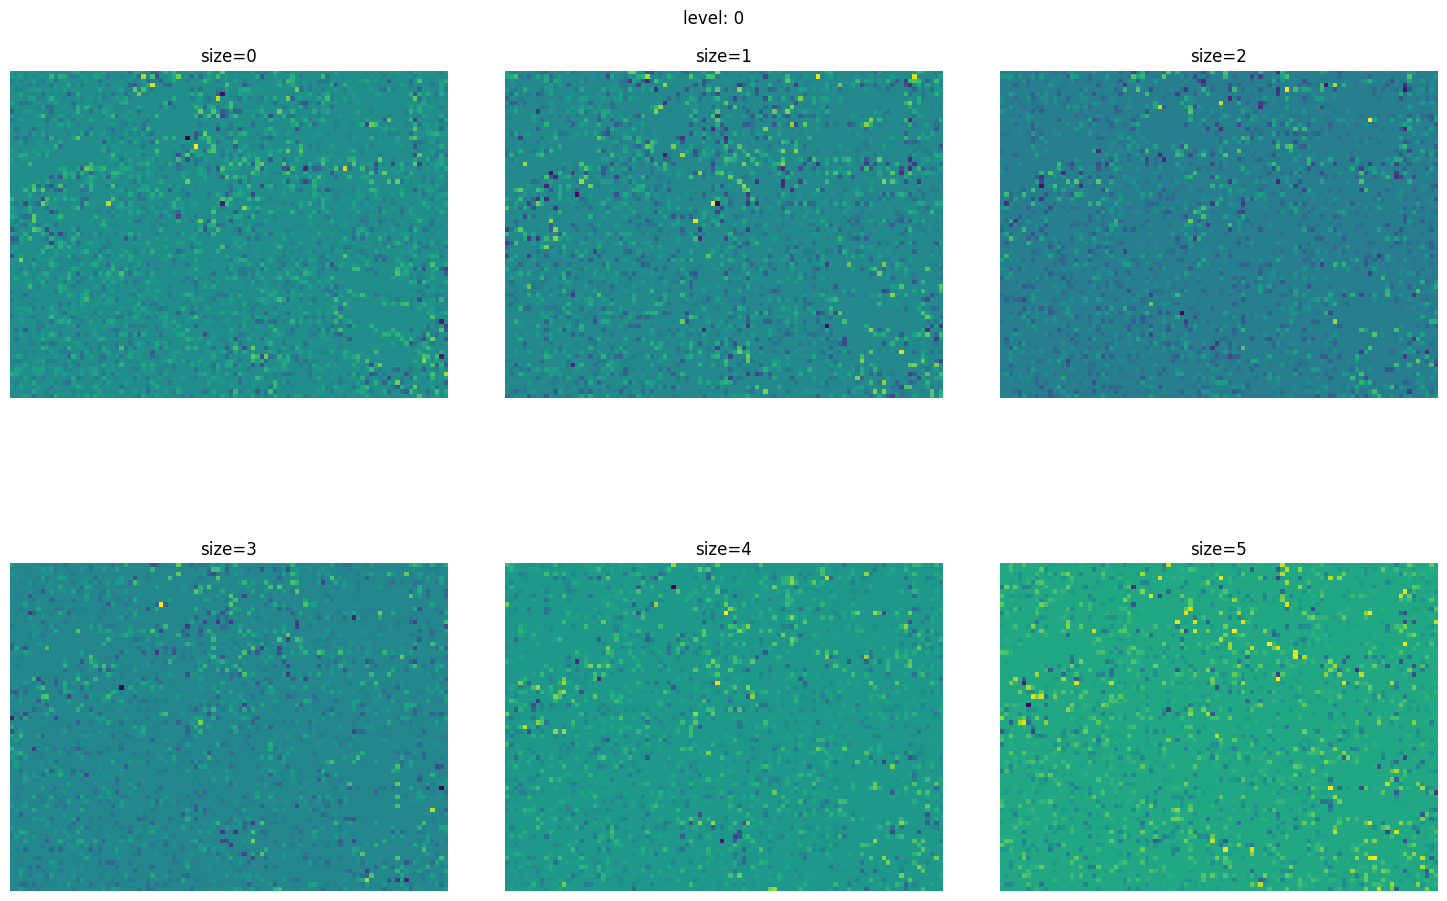

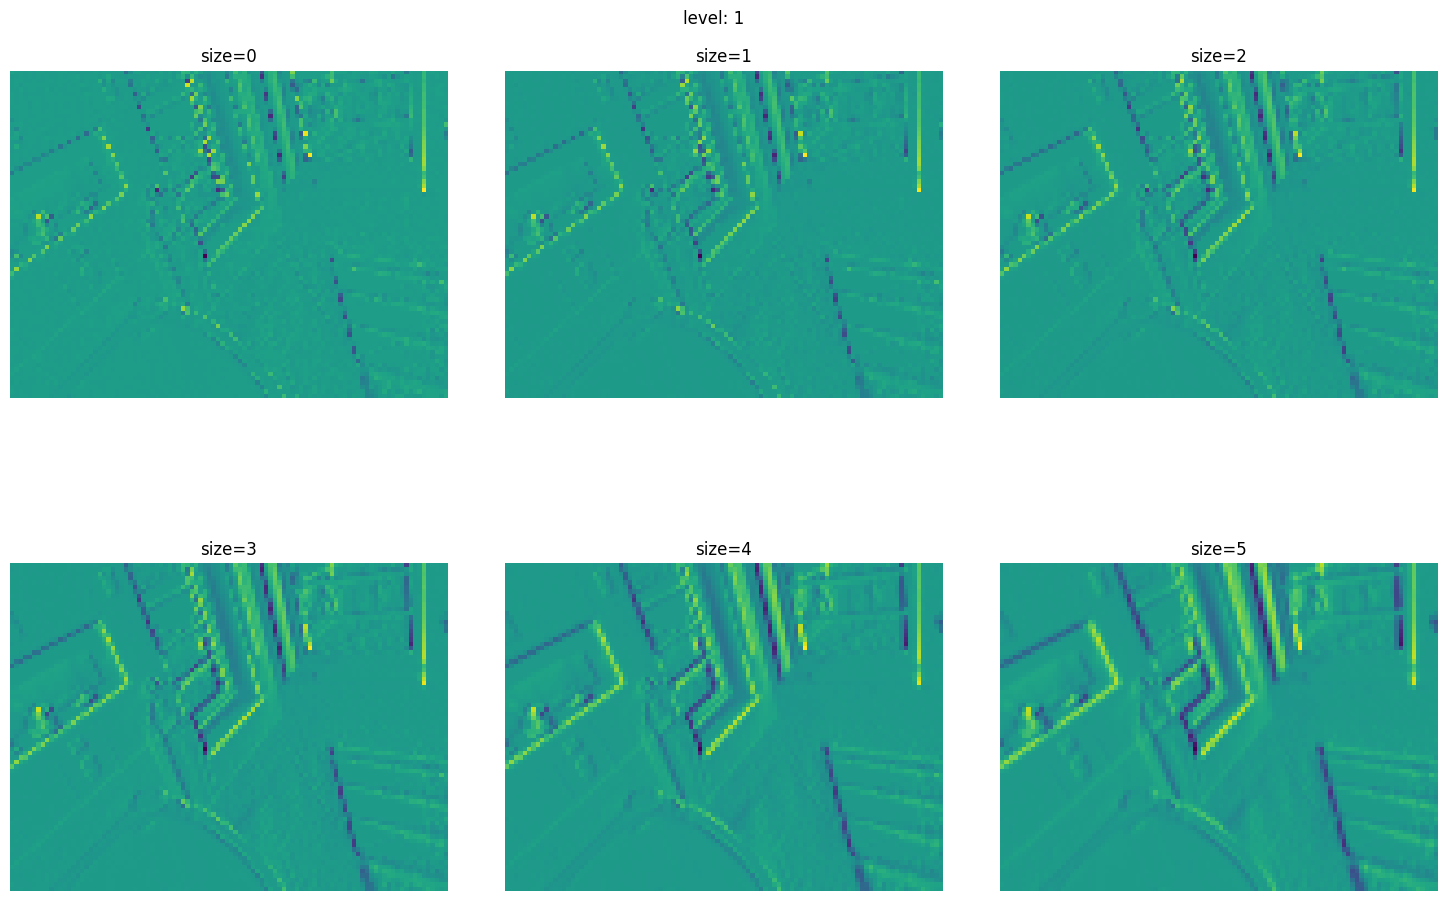

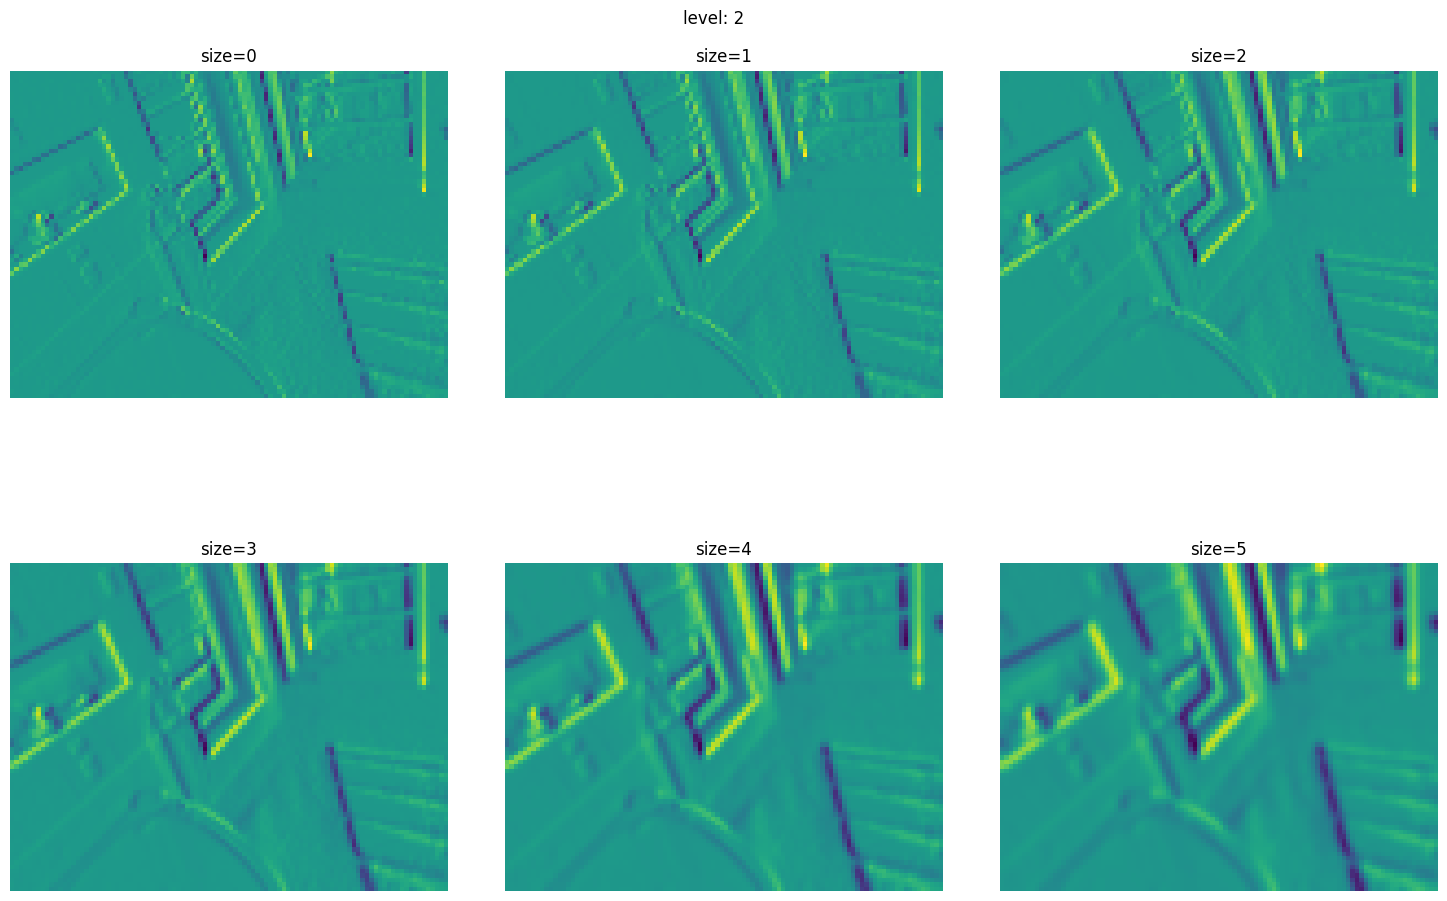

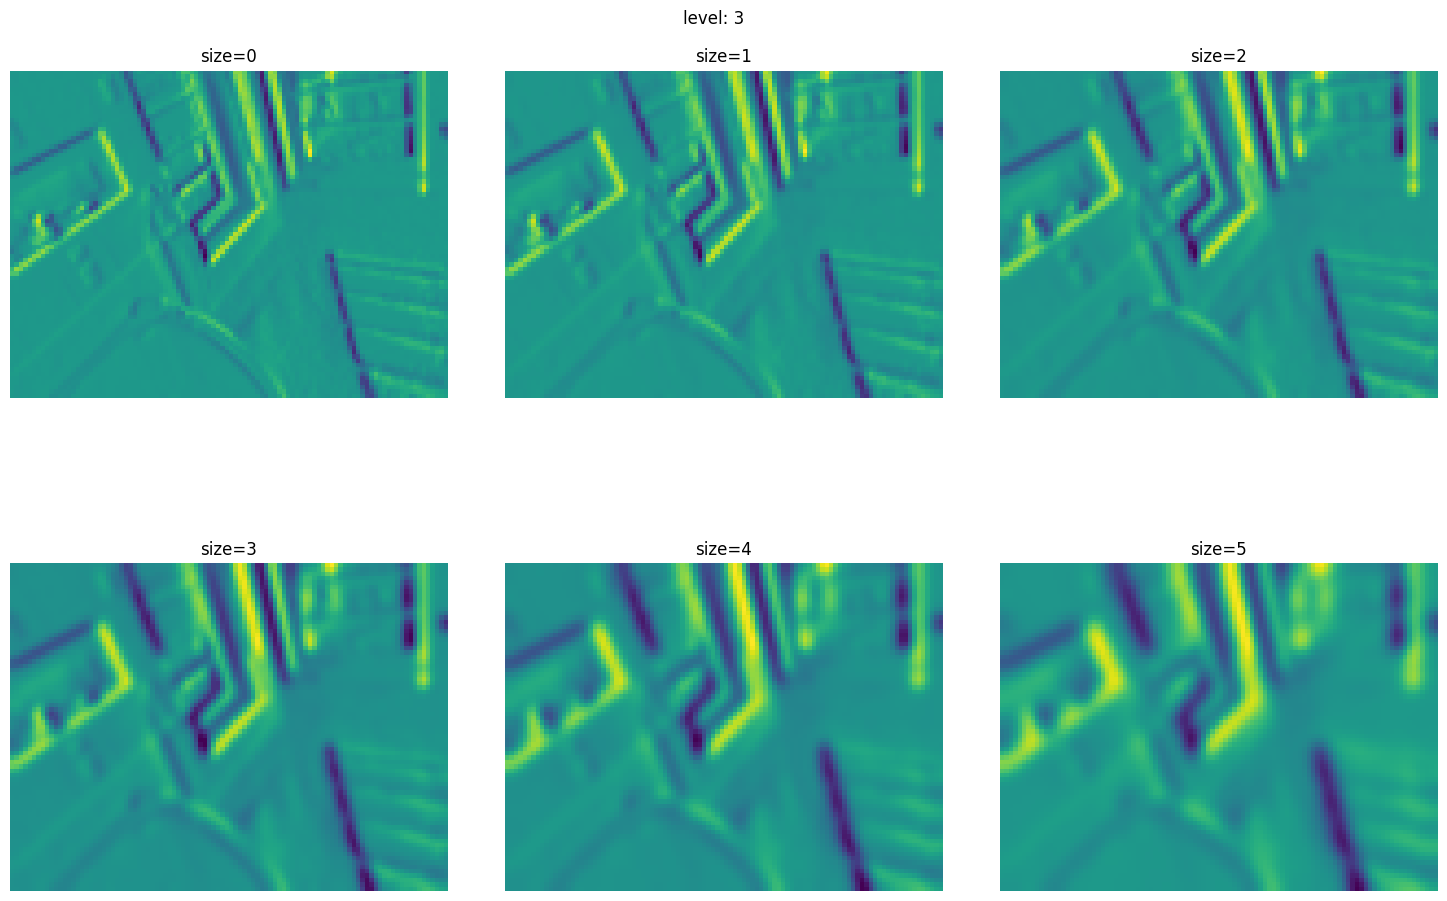

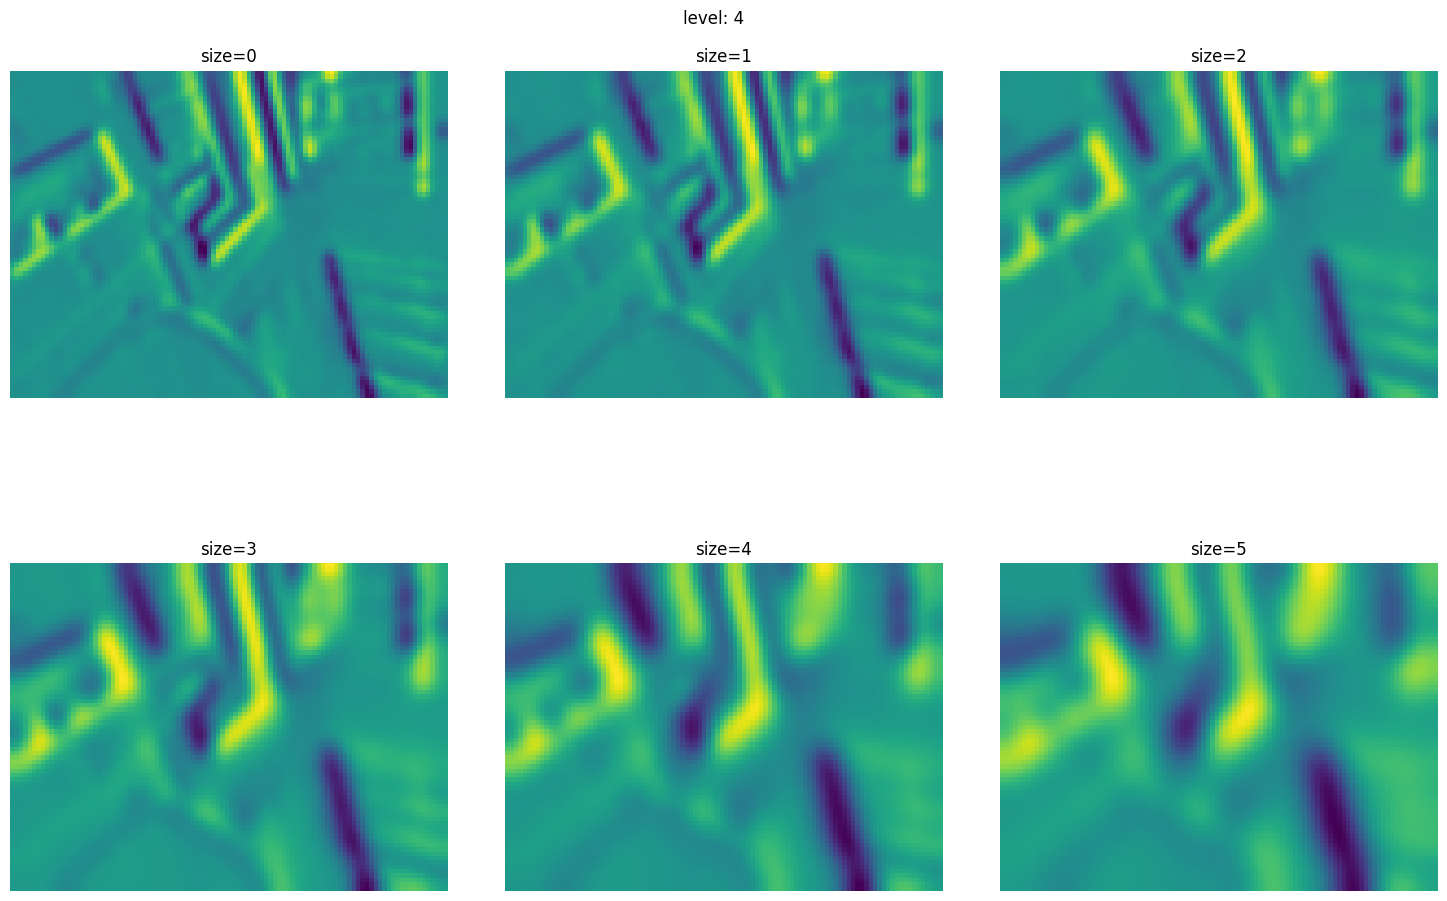

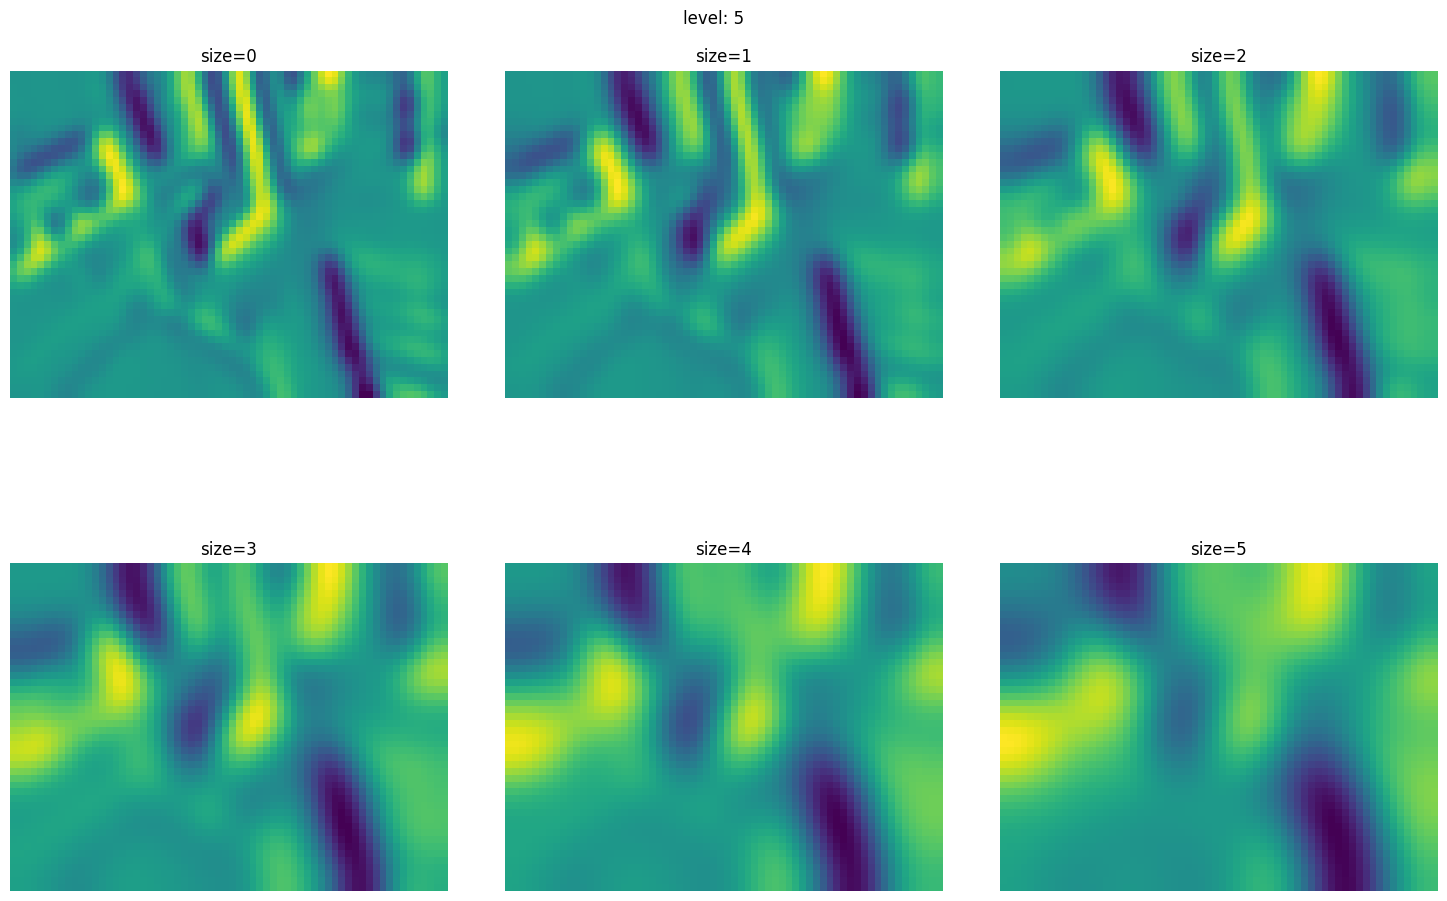

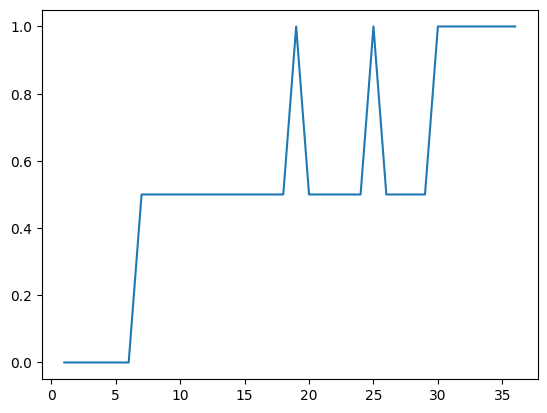

scale_pyr: interpolation=nearest, compensate_gauss: False, compensate_interpolation: True


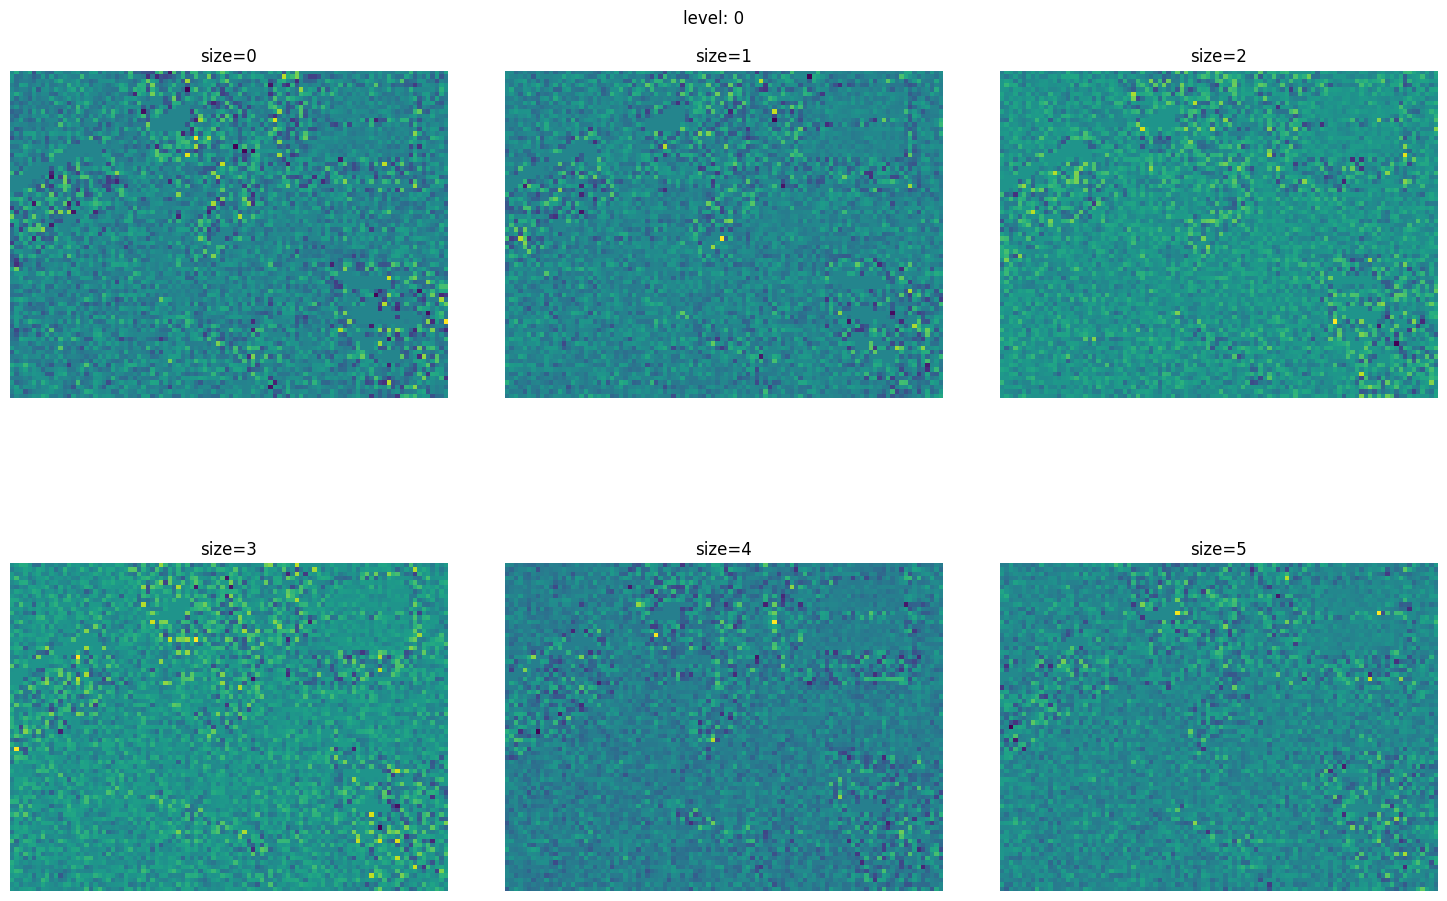

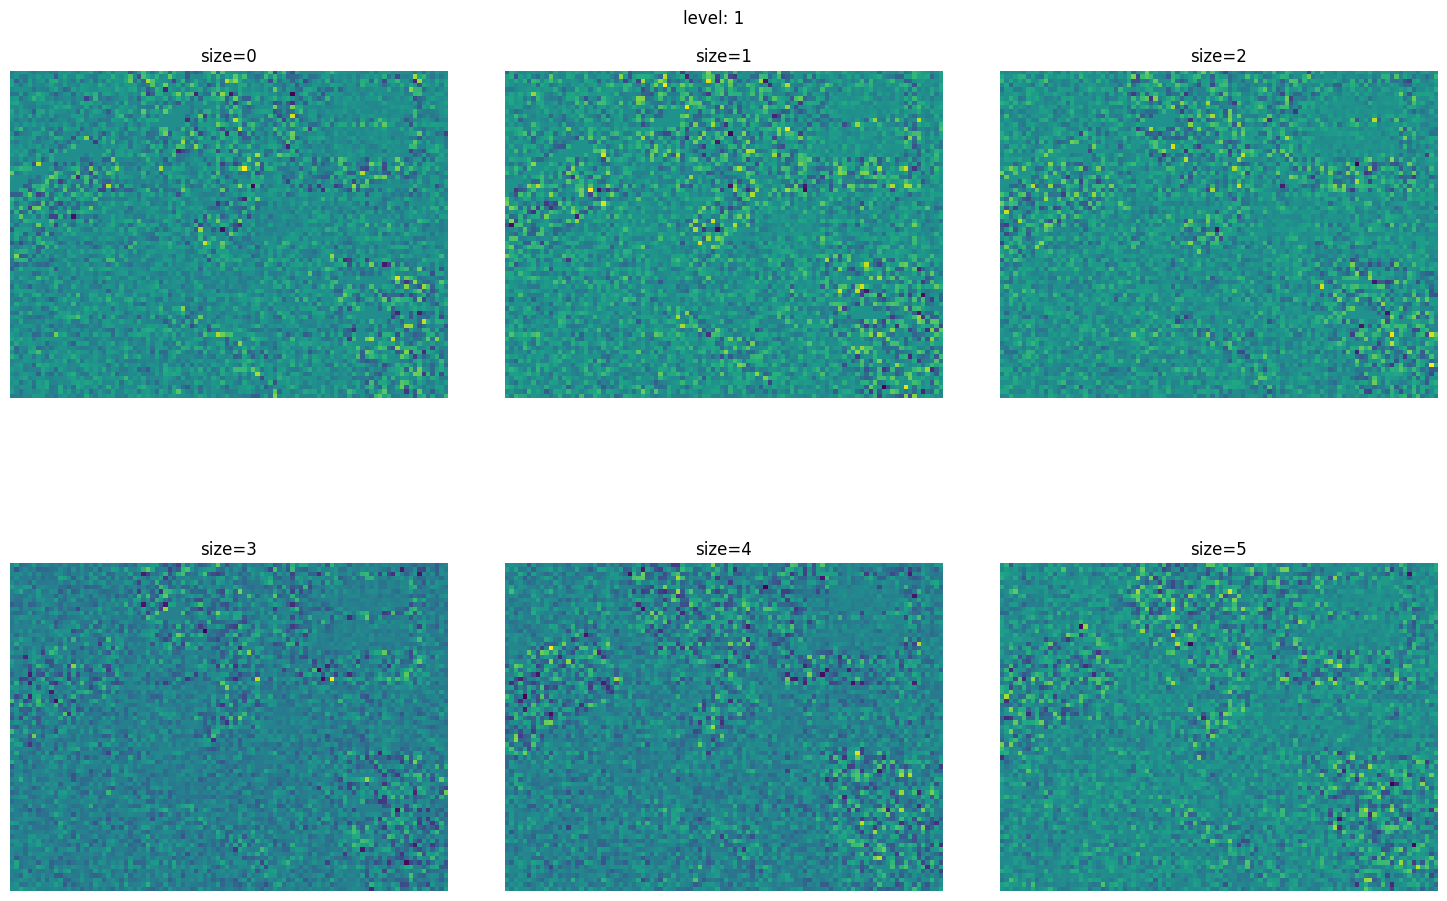

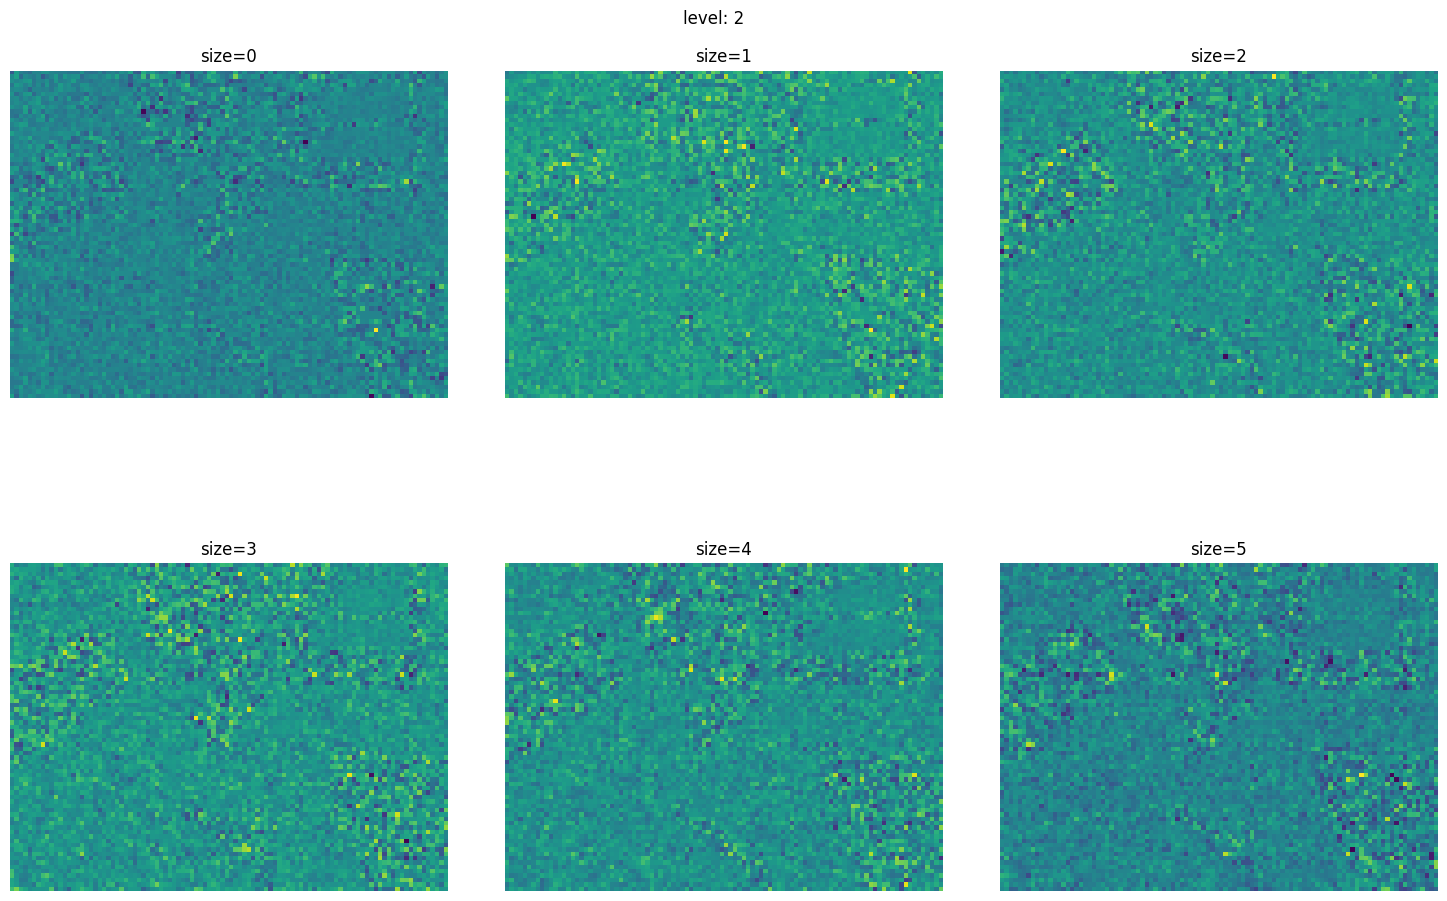

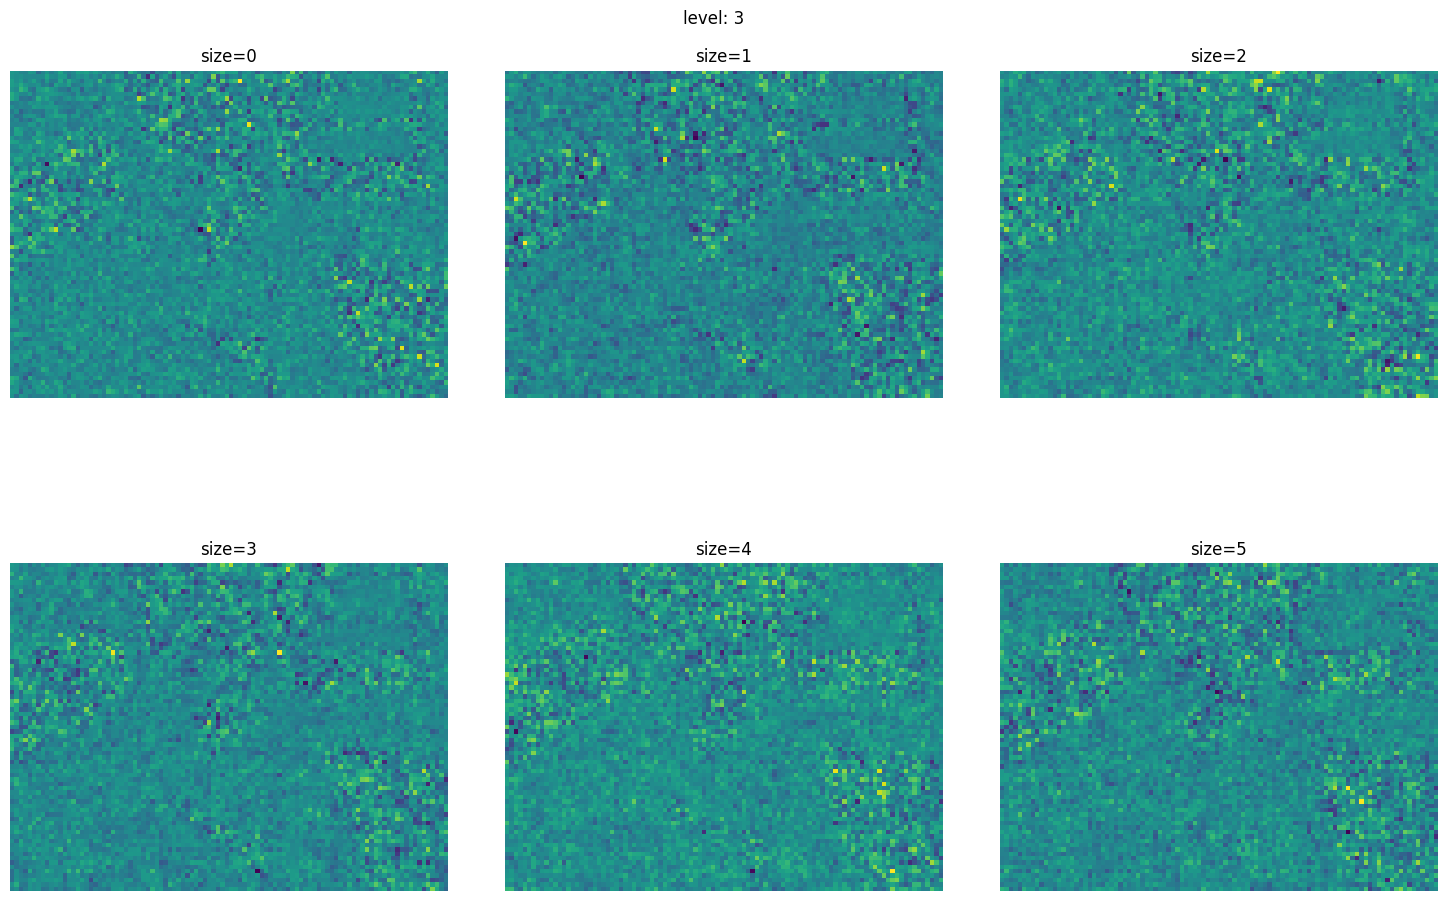

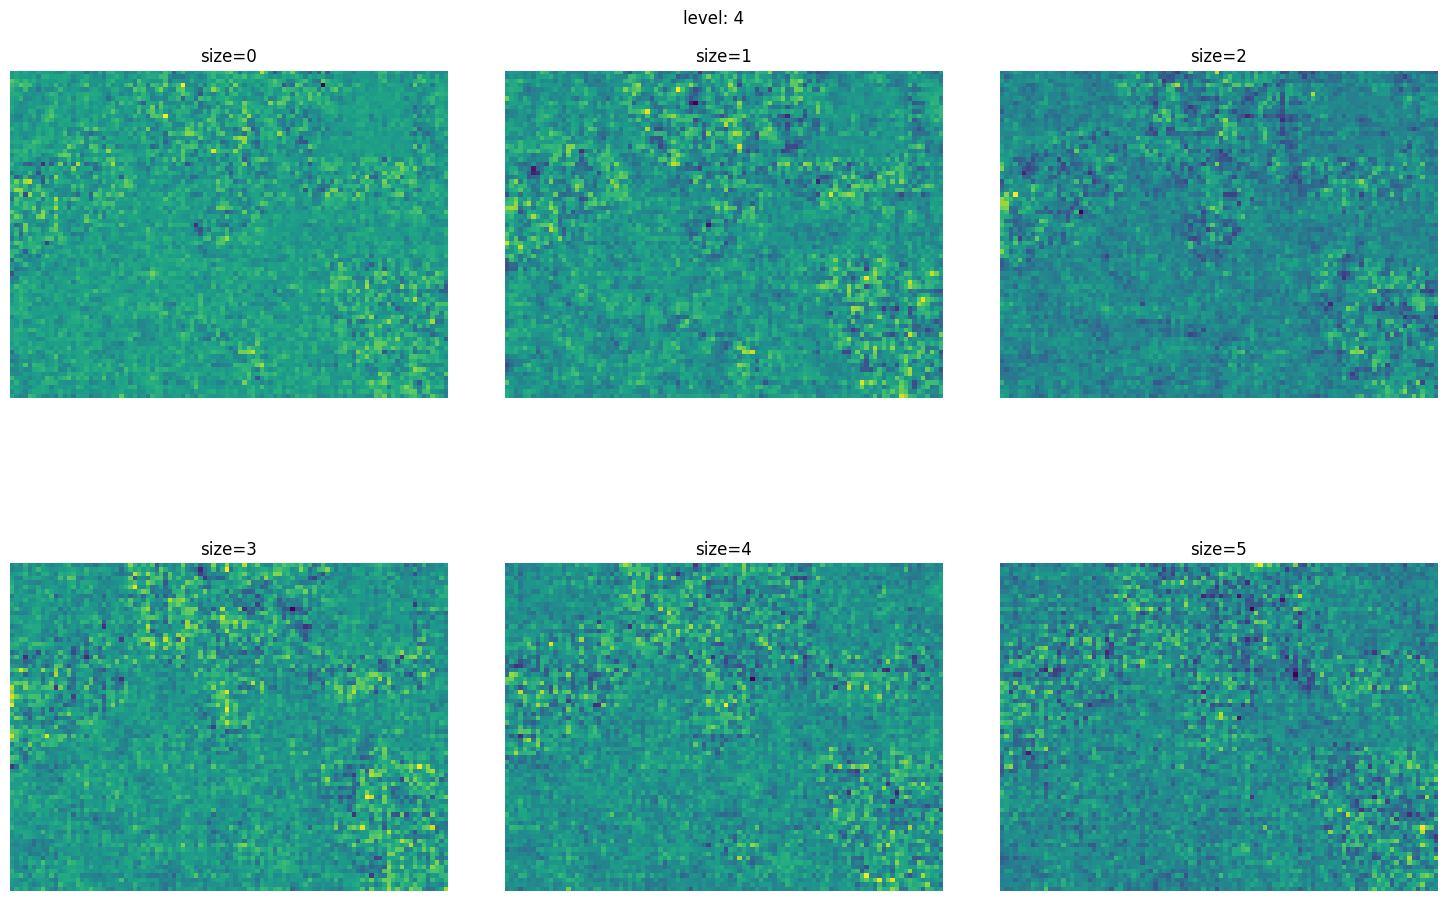

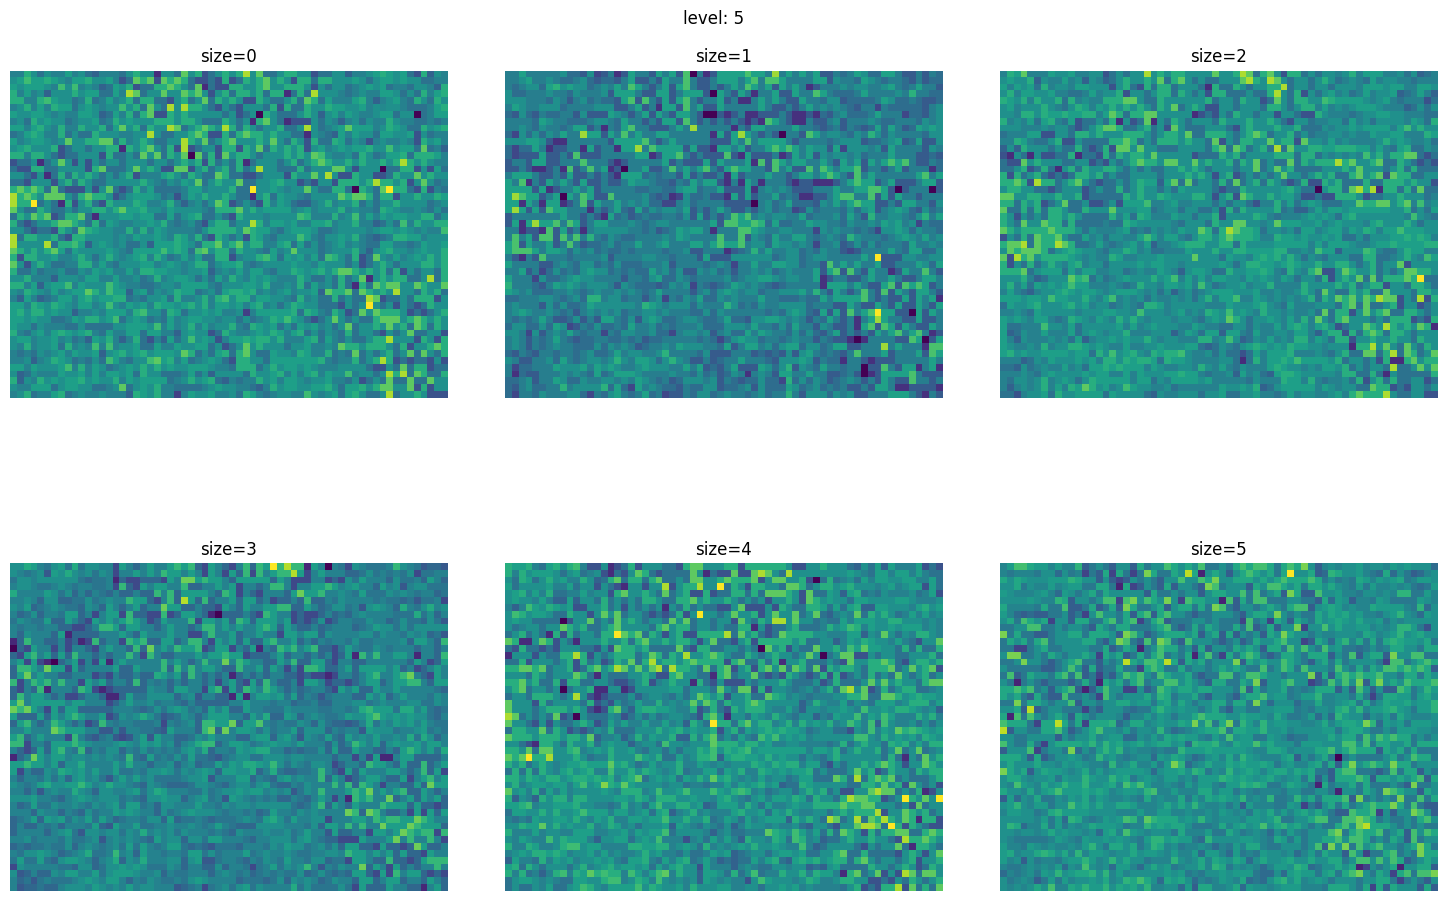

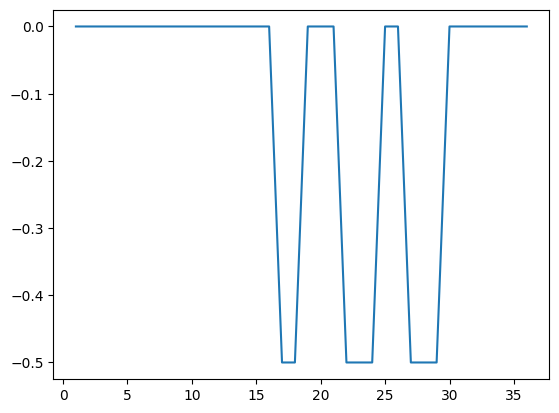

scale_pyr: interpolation=nearest, compensate_gauss: True, compensate_interpolation: True


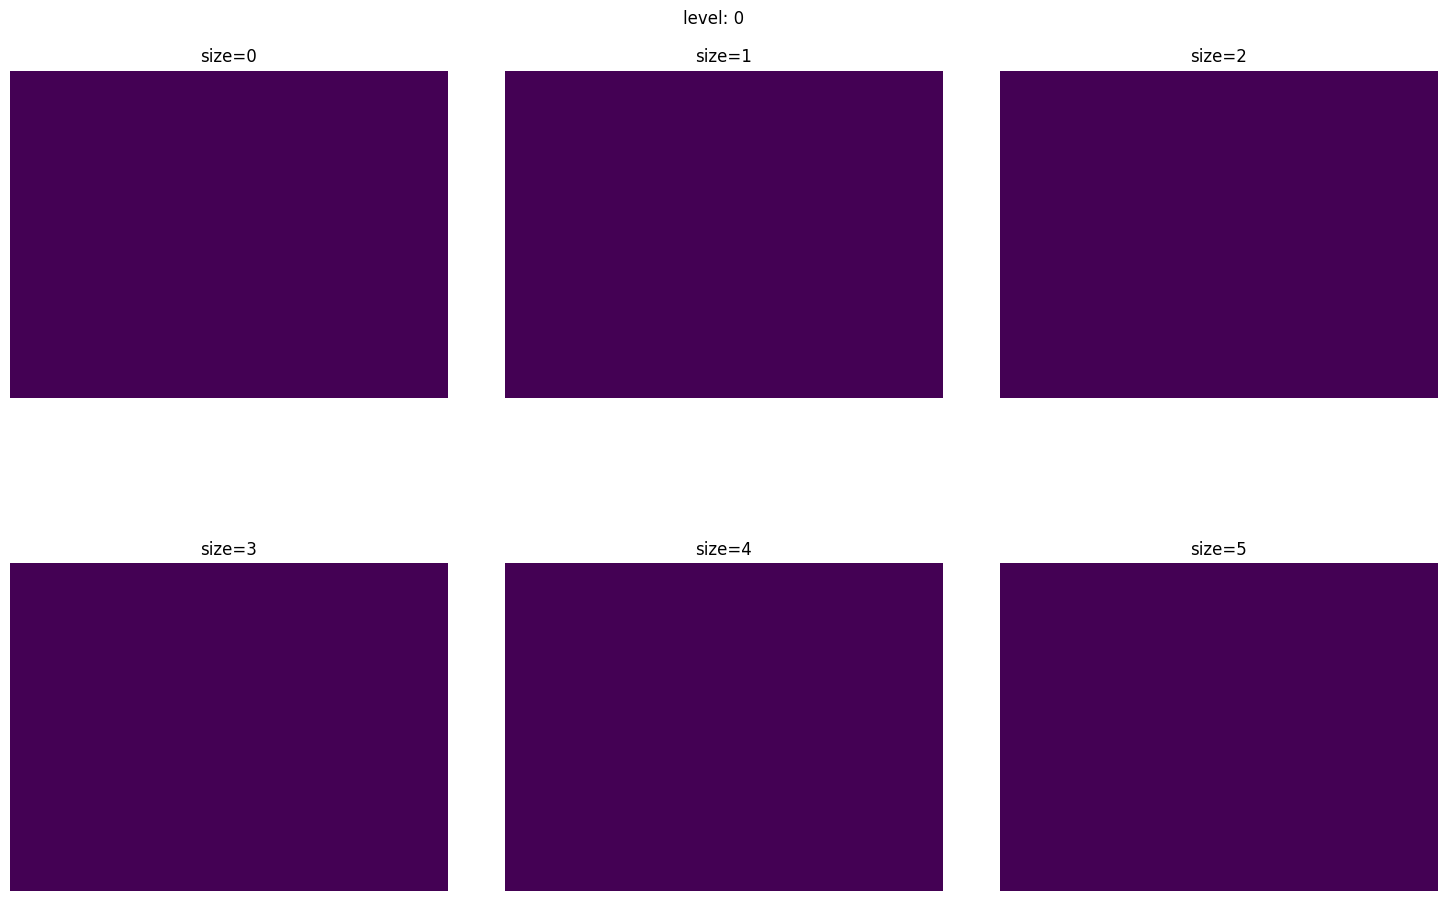

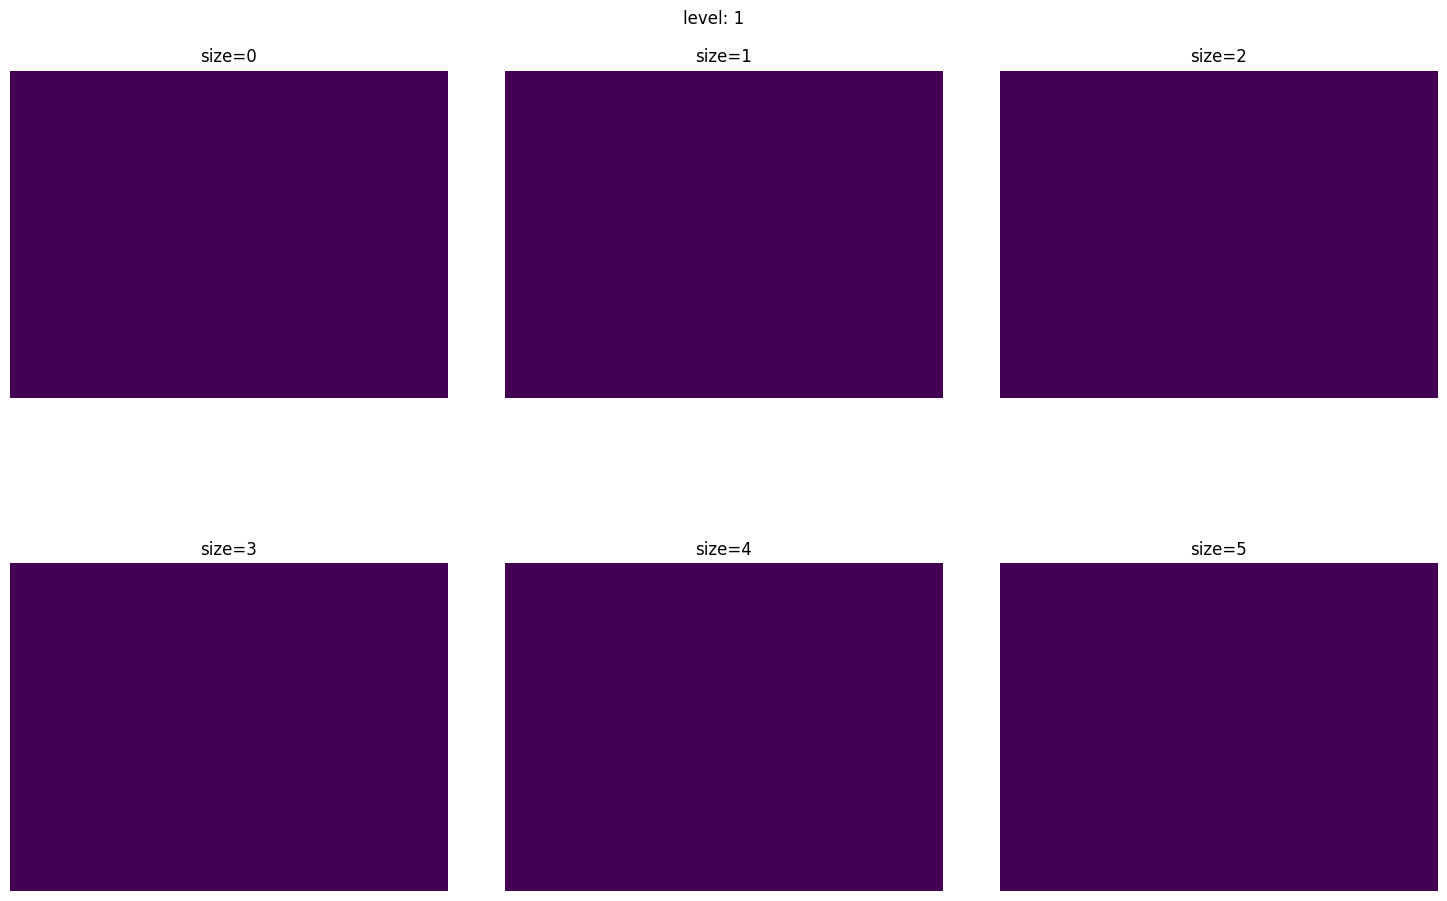

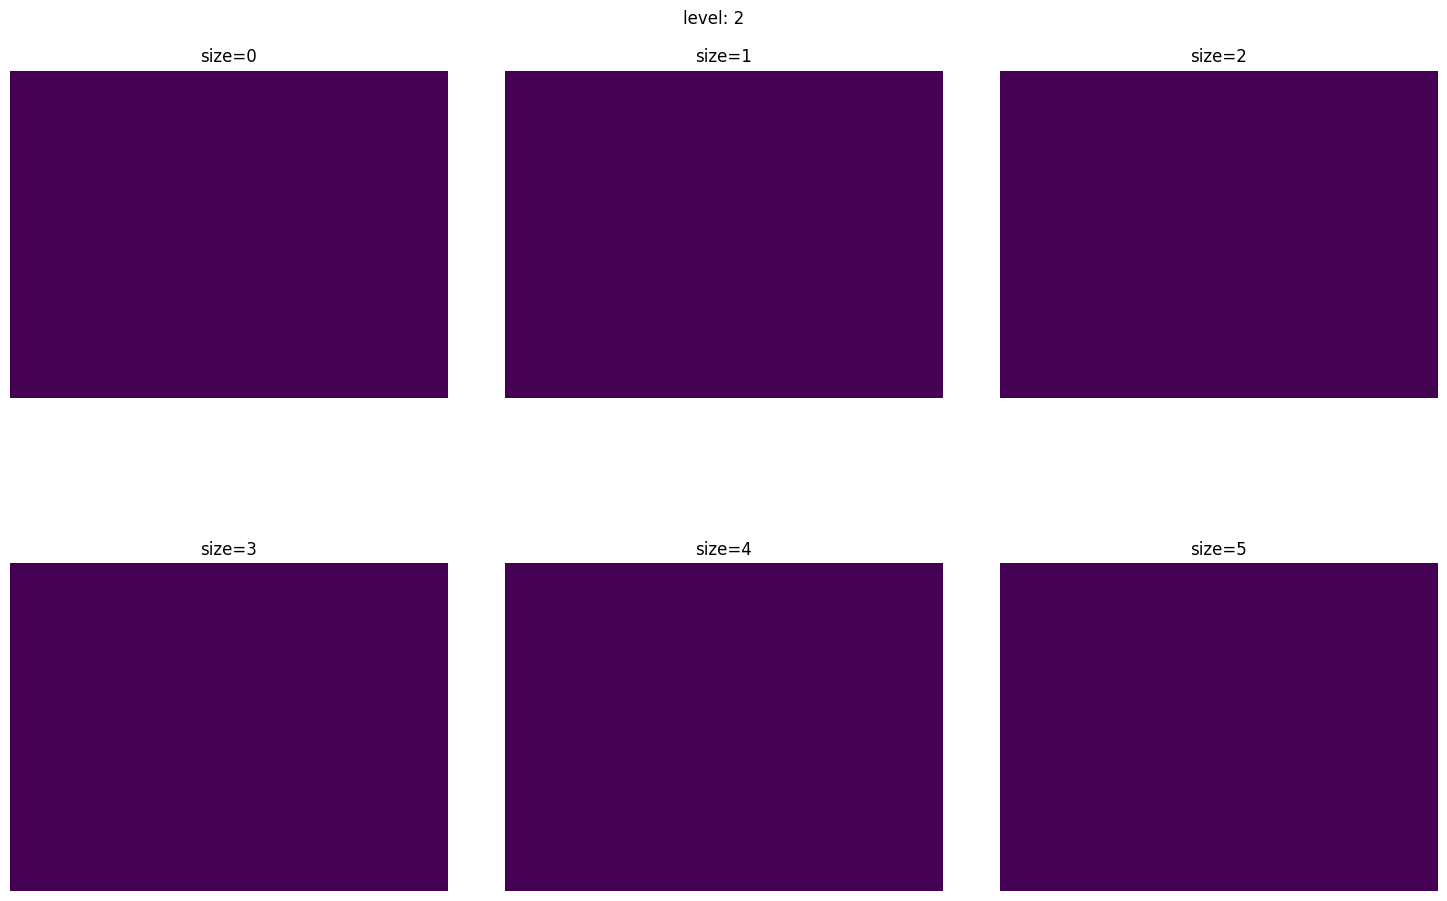

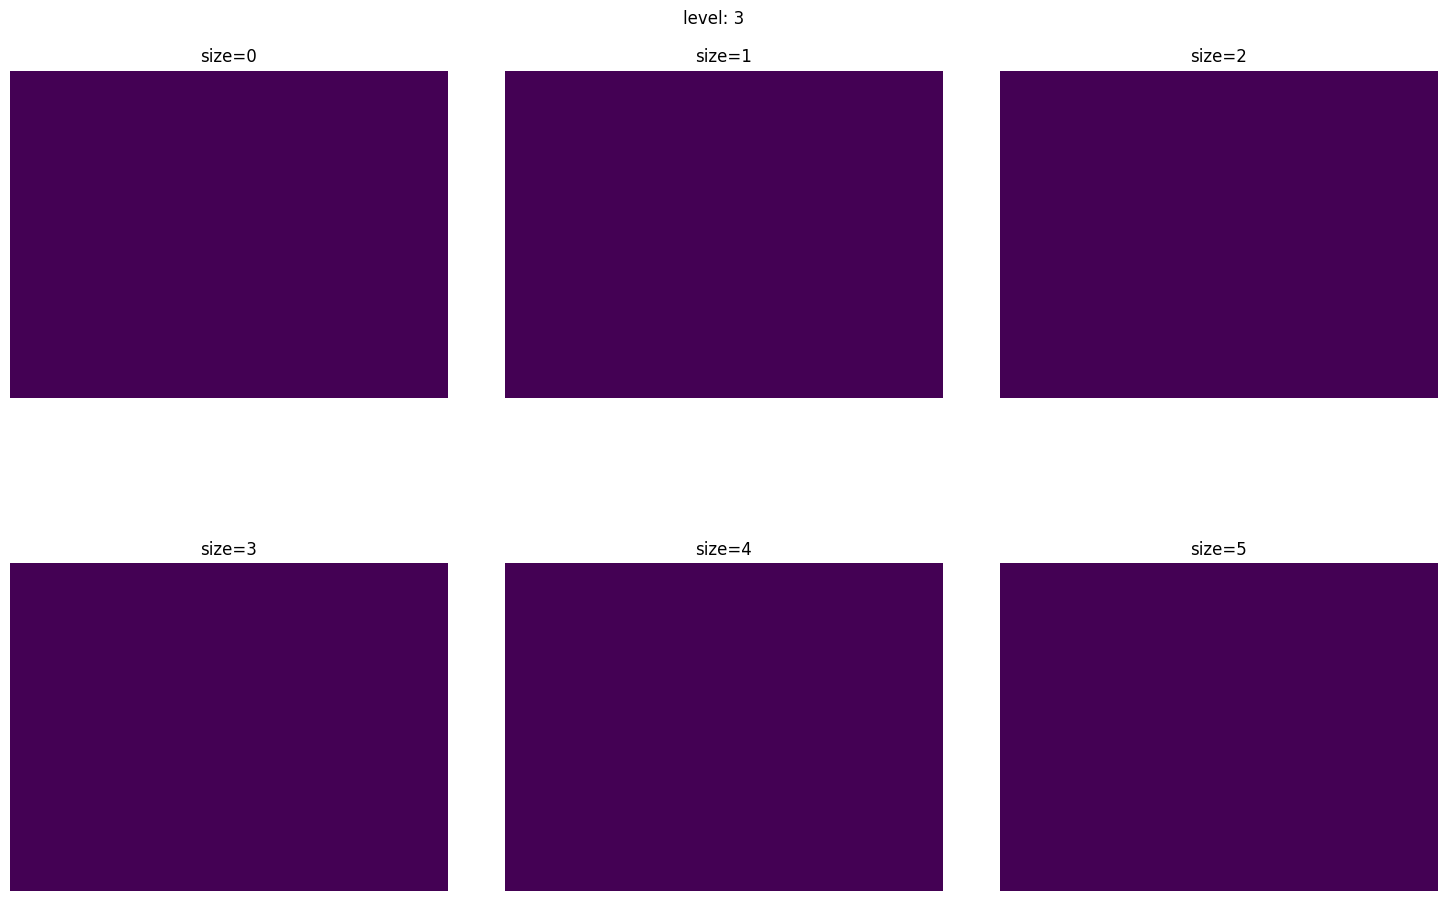

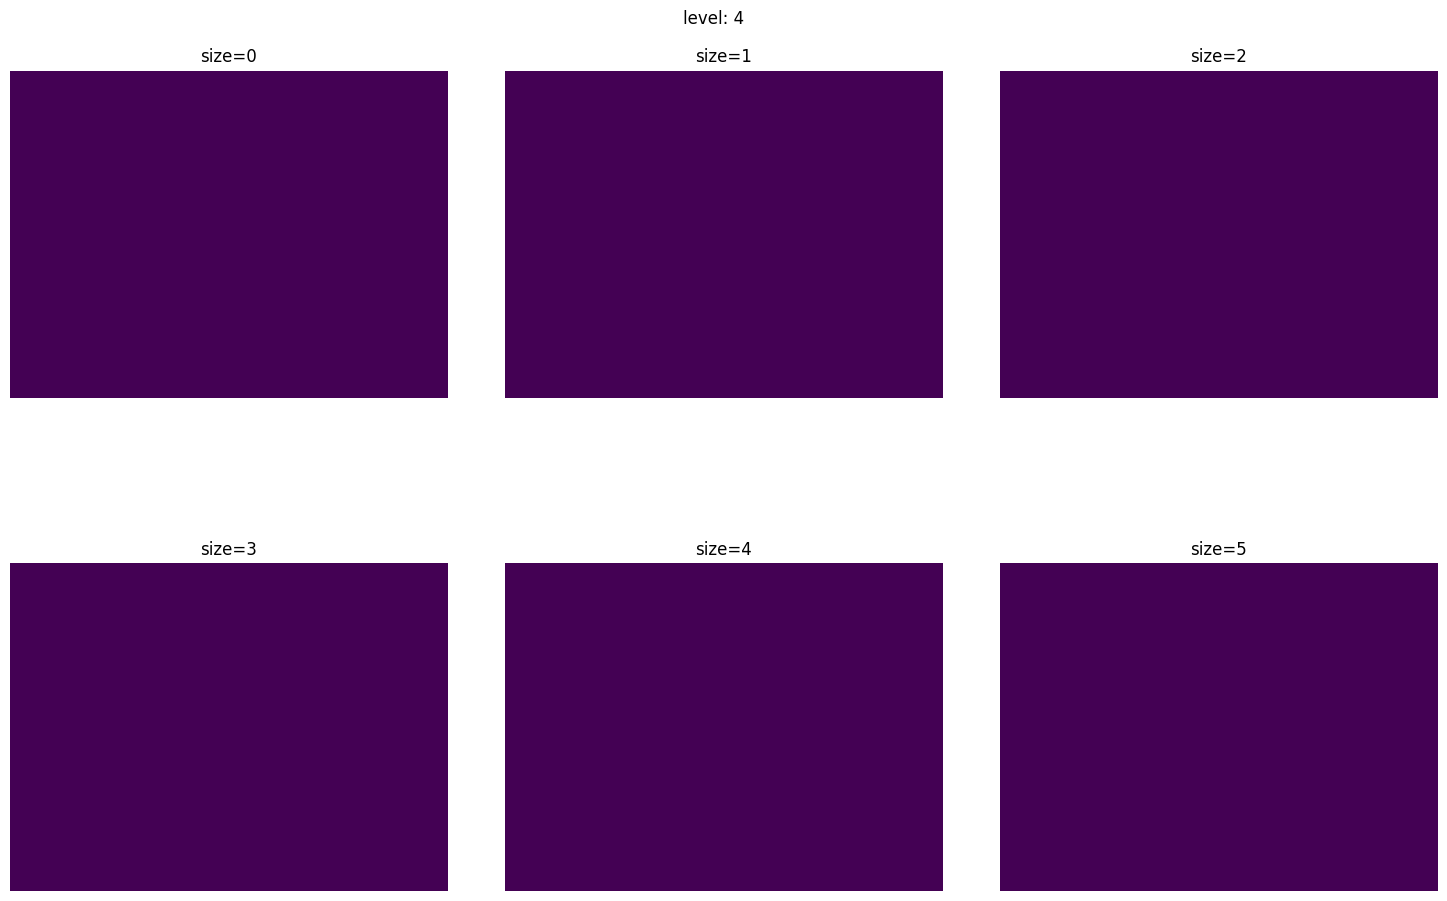

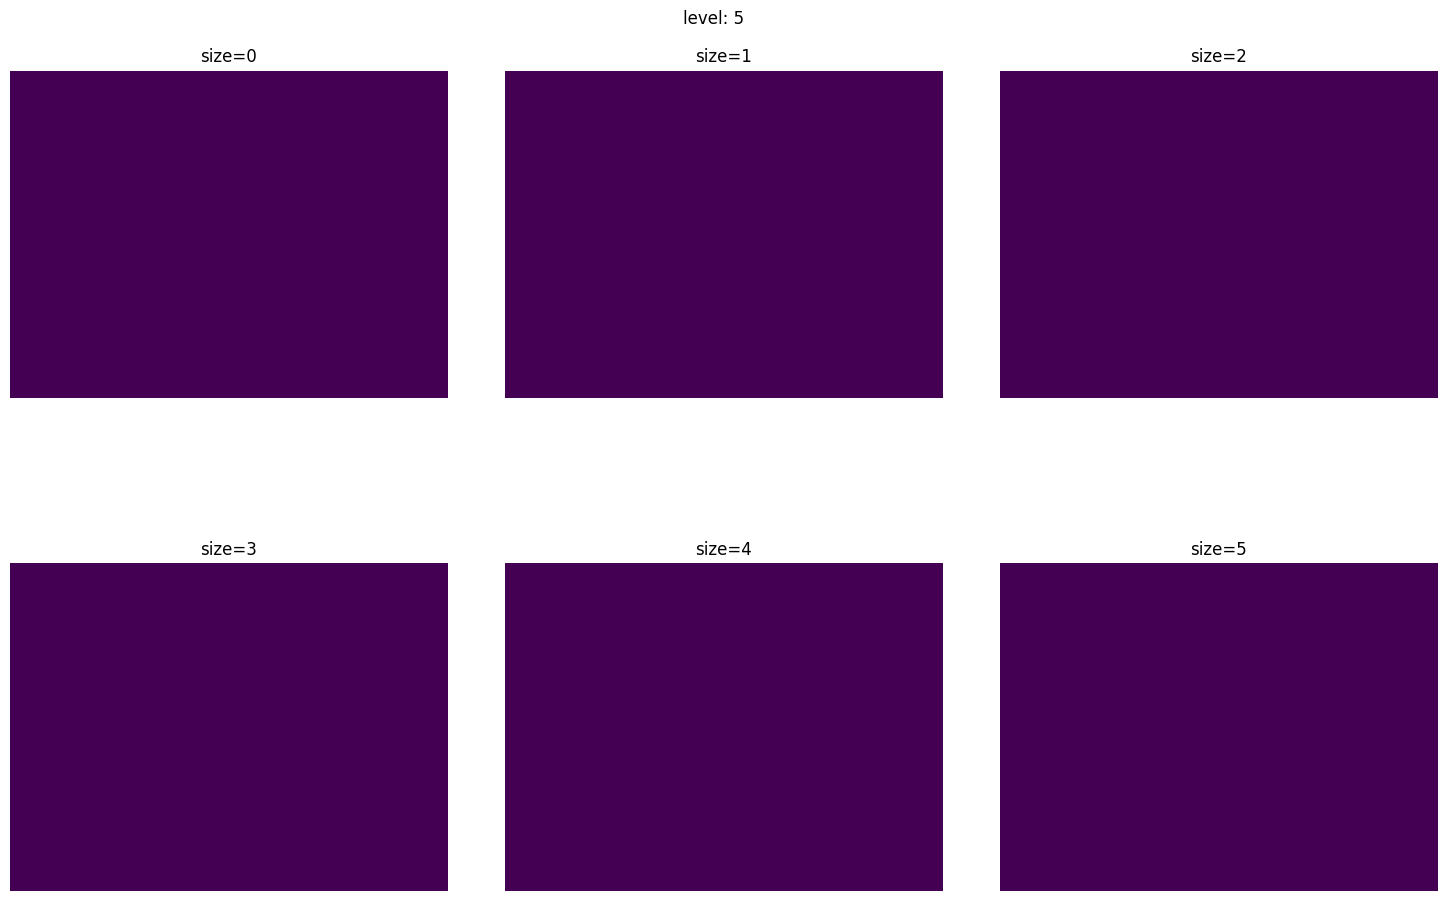

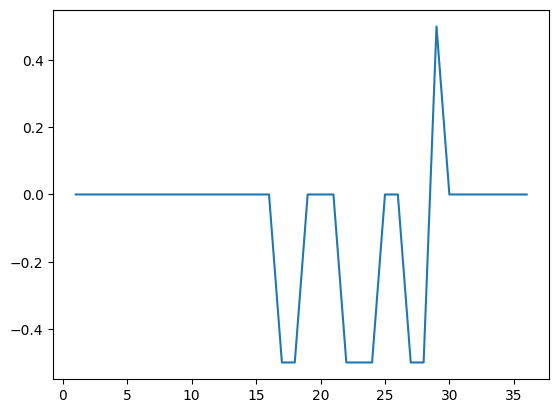

scale_pyr: interpolation=bilinear, compensate_gauss: False, compensate_interpolation: False


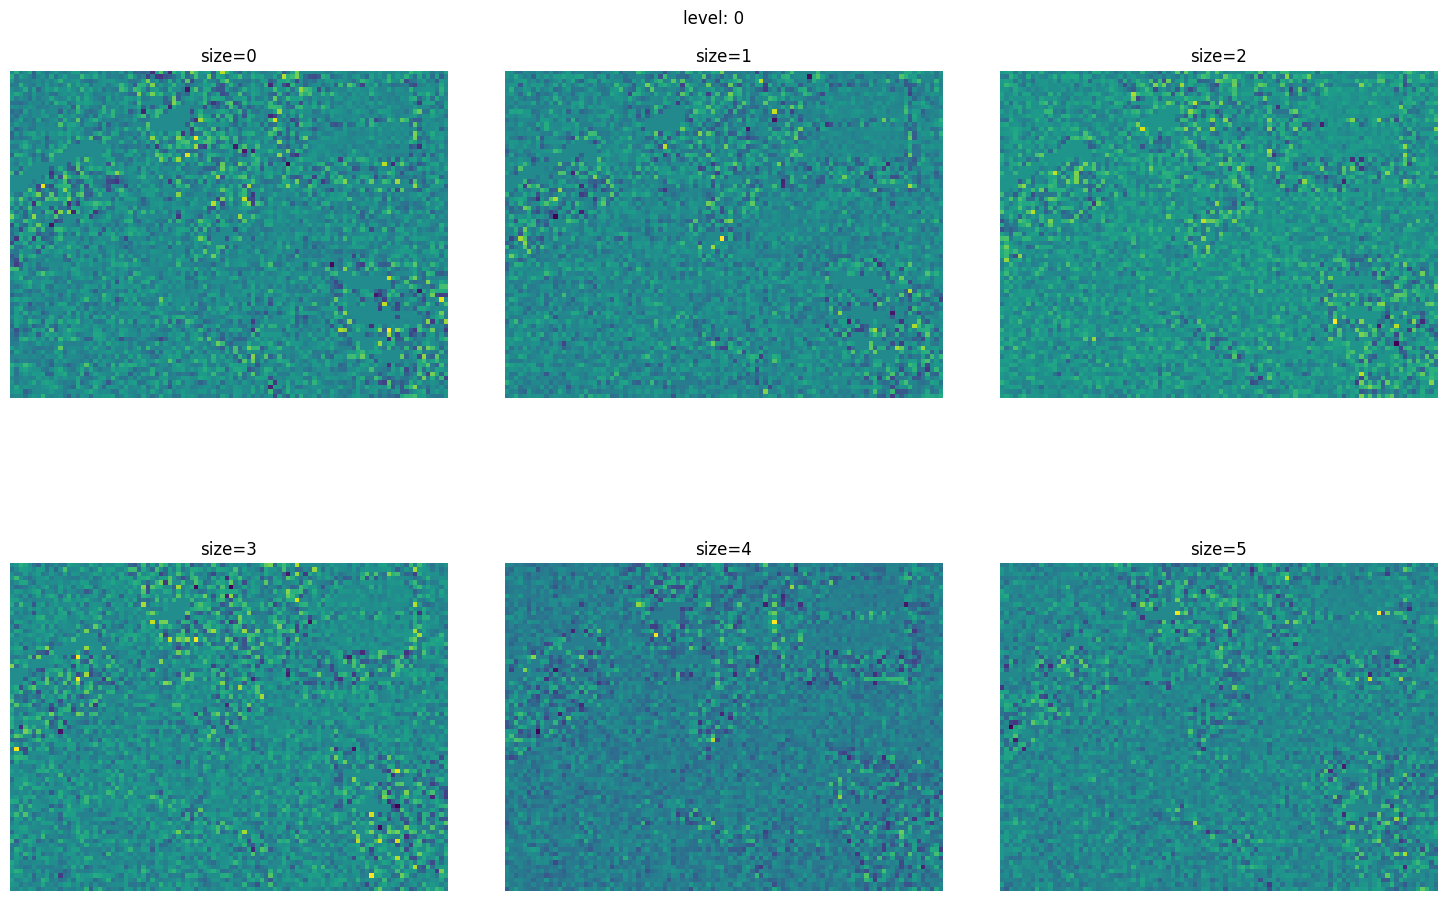

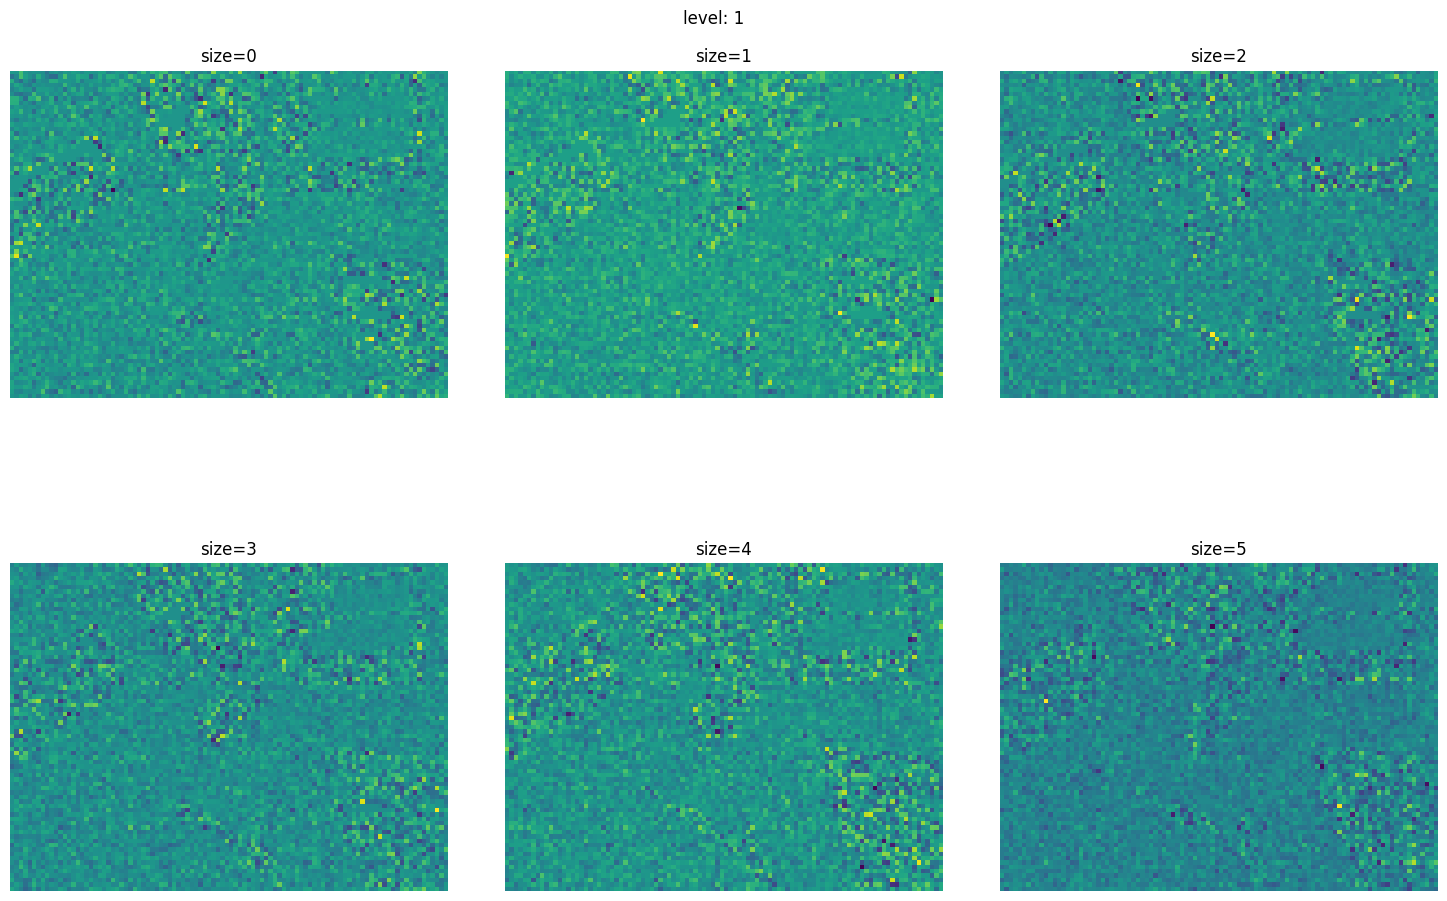

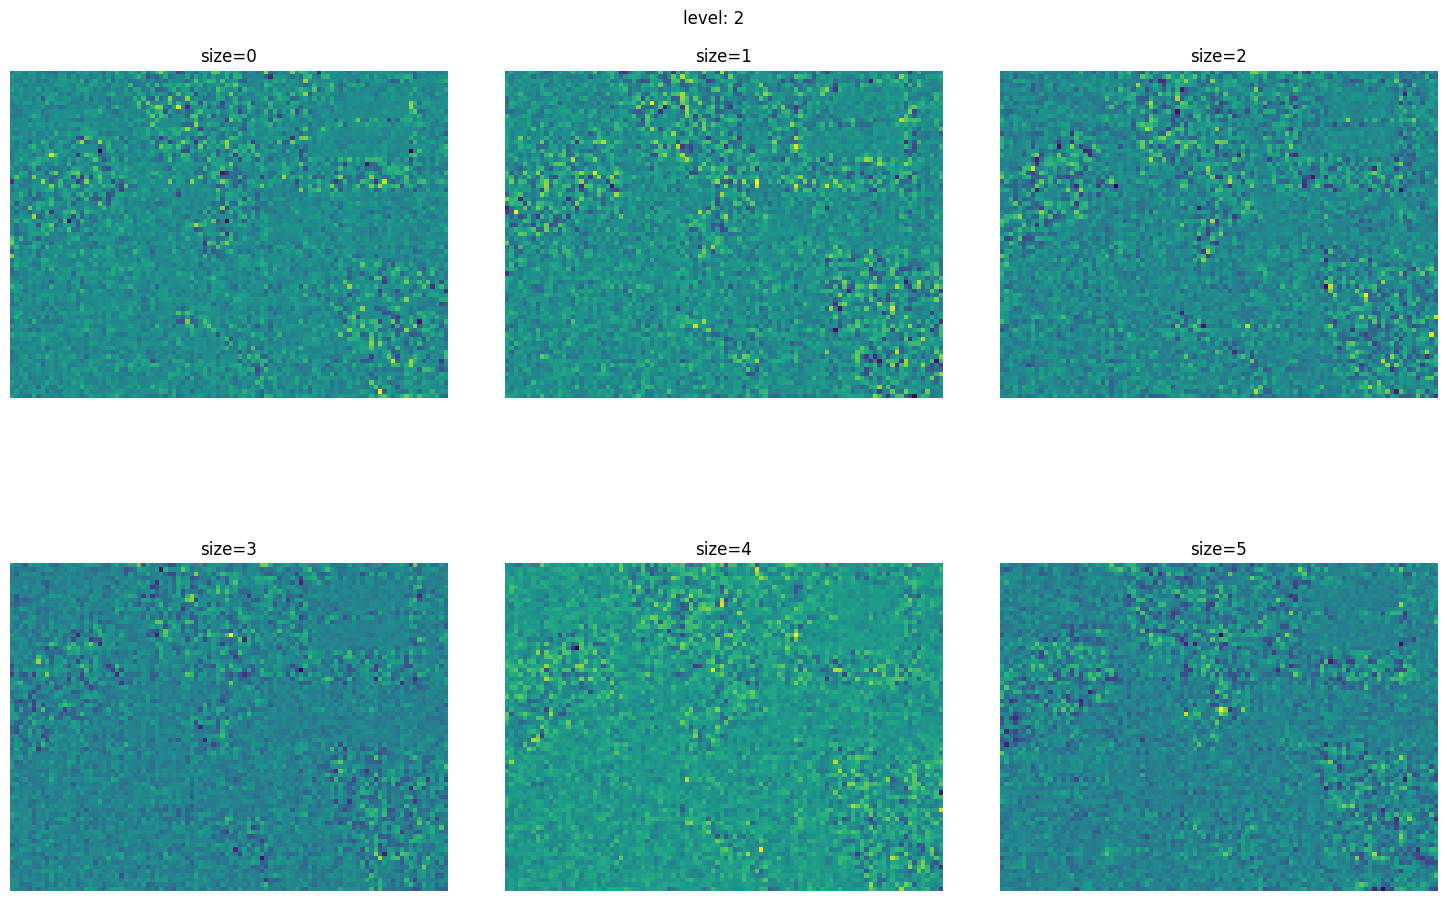

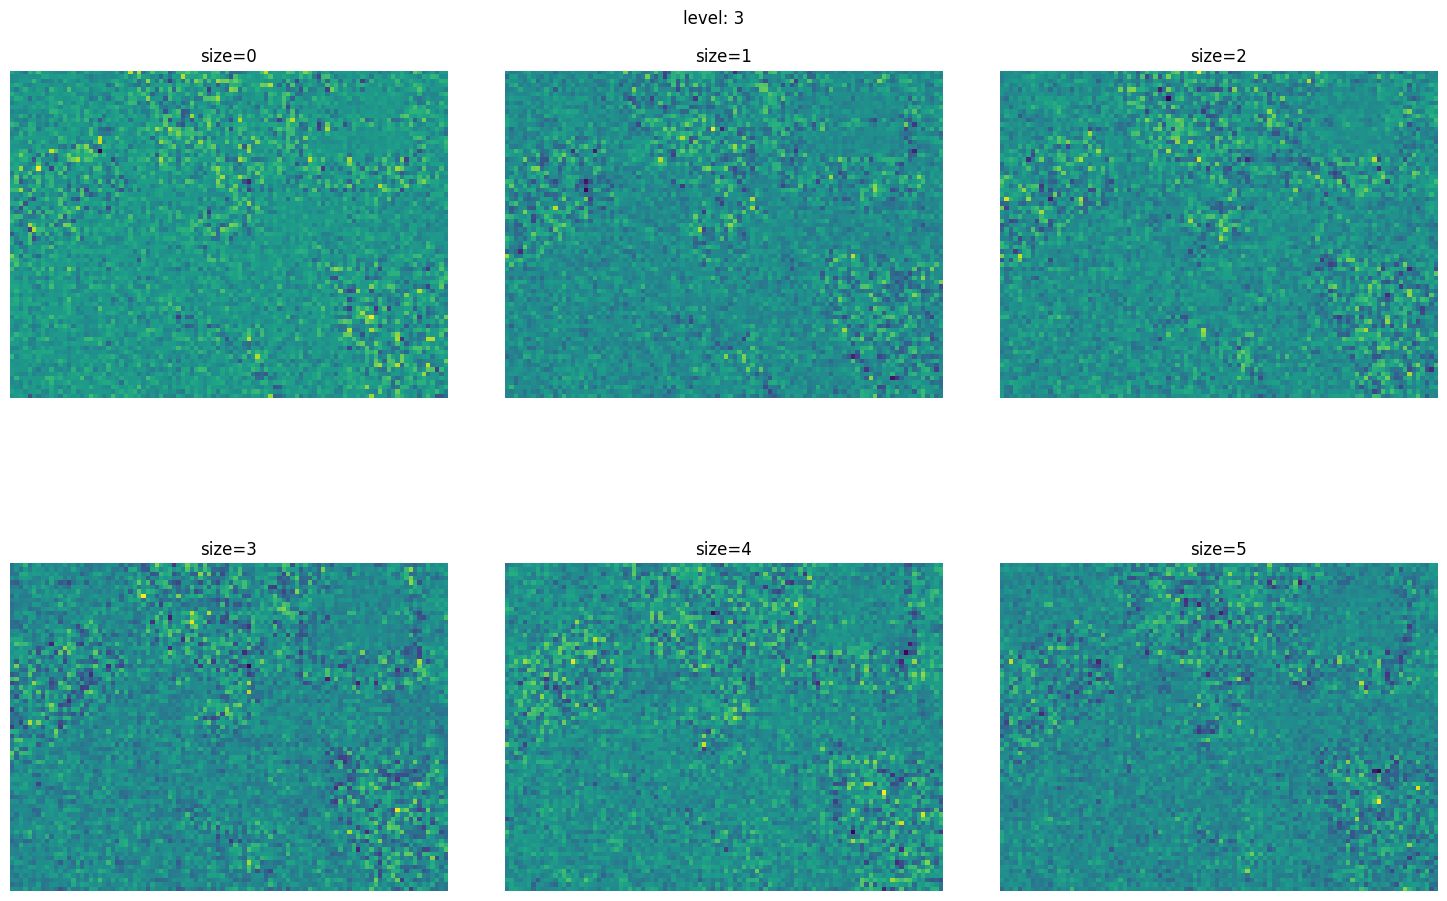

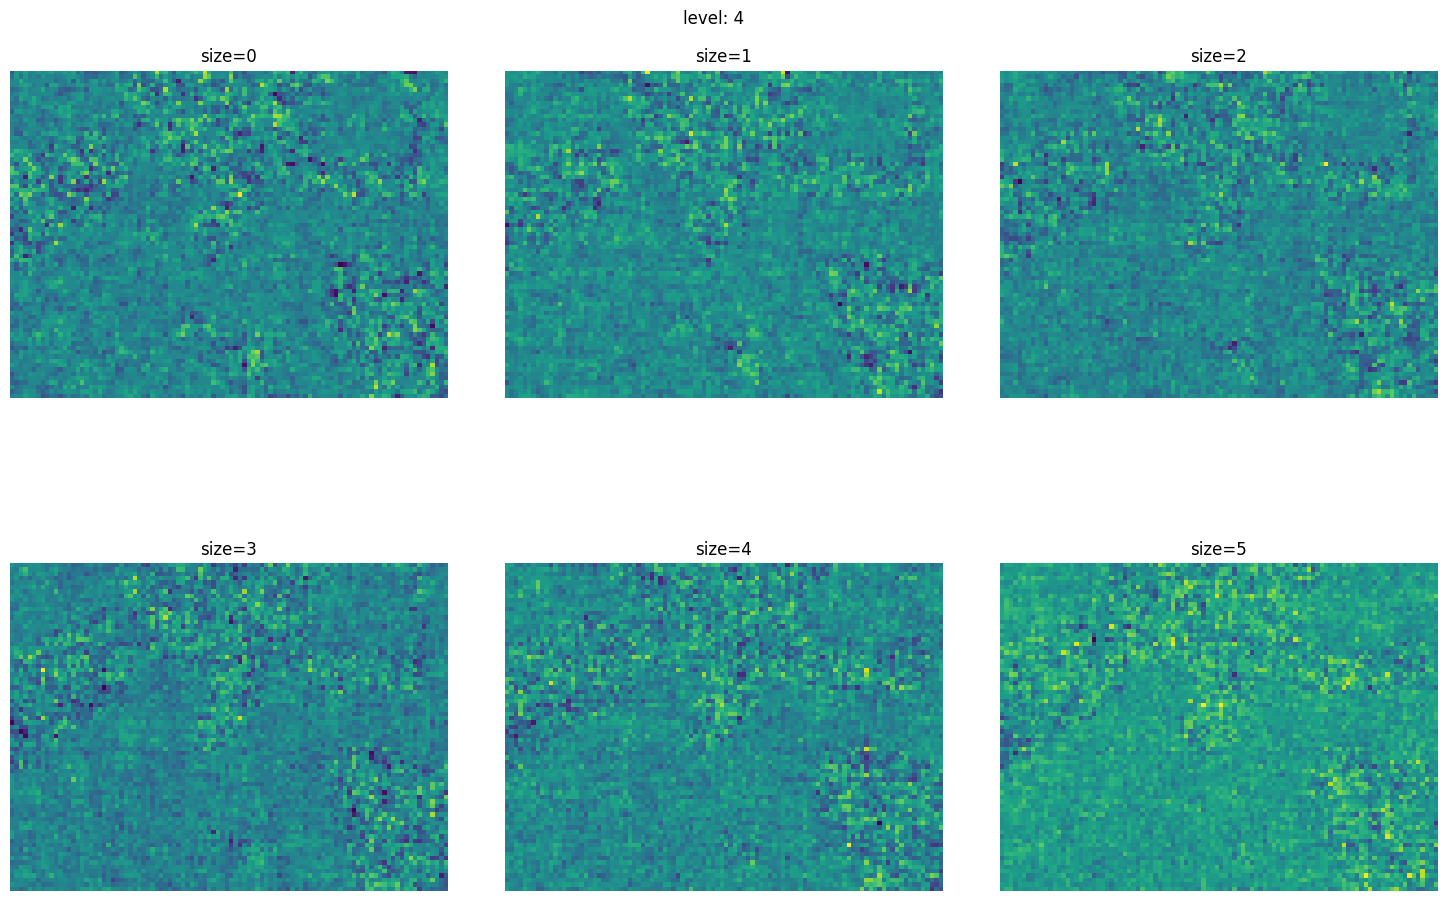

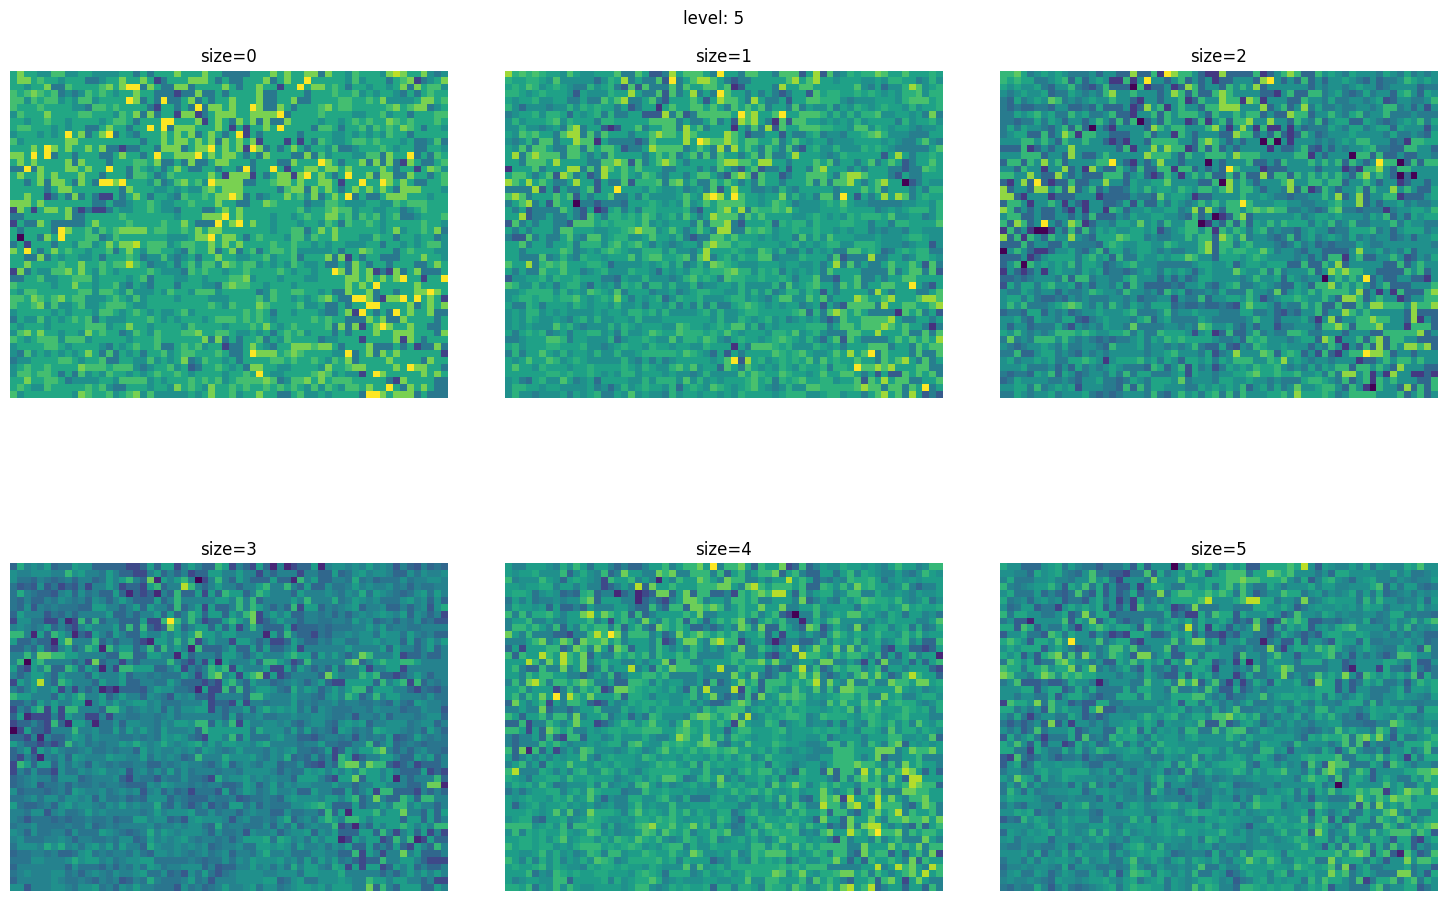

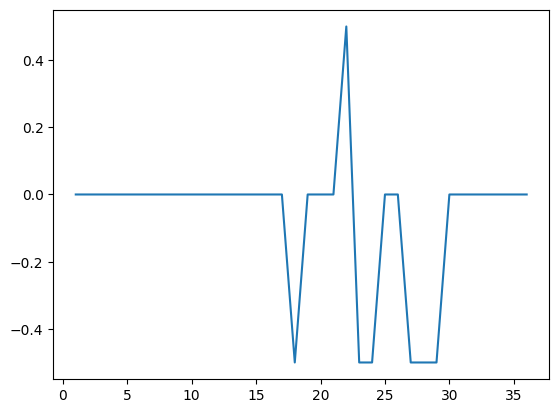

In [2]:
import math
import matplotlib.pyplot as plt

scale_factor = 2

def prepare(title, rows=2, cols=3):

    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    fig.tight_layout()
    fig.suptitle(title)
    return axs

def add(axs, r, c, img, title):
    scale = 100 / img.shape[3]
    if scale < 1:
        img = F.interpolate(img, scale_factor=scale, mode='bilinear', align_corners=False)
    img = img[0, 0]
    axis = axs[r, c]
    axis.set_axis_off()
    axis.set_title(title)
    axis.imshow(img)

def scale_and_pad(input):

    input = F.interpolate(input, scale_factor=scale_factor, mode='bilinear', align_corners=False)
    input = F.pad(input, (scale_factor, scale_factor, scale_factor, scale_factor), 'constant')
    return input

def show_pyrs(scale_pyr, compensate_gauss, compensate_interpolation, show_imgs, show_plot):
          
    m = rotate_experiment_loop_pyr(1, scale_pyr, compensate_gauss, compensate_interpolation)
    
    shifts = []
    
    for sp, sp_r in m['frame.0004.color.jpg']:
        for i in range(6):
            if show_imgs:
                axs = prepare(f"level: {i}", rows=2, cols=3)
            for j in range(6):
                if show_imgs:
                    level_size1 = sp[i][:, 0:1, j]
                    level_size2 = sp_r[i][:, 0:1, j]
                    add(axs, j // 3, j % 3, level_size1 - level_size2, title=f"size={j}")
                else:
                    level_size1 = scale_and_pad(sp[i][:, 0:1, j])
                    level_size2 = scale_and_pad(sp_r[i][:, 0:1, j])

                if show_plot:
                    r = torch.arange(-scale_factor, scale_factor+1)
                    corrs = torch.zeros(len(r))
                    for i_s, shift in enumerate(r):
                        if shift > 0:
                            img1 = level_size1[:, :, :, shift:]
                            img2 = level_size2[:, :, :, :-shift]
                        elif shift < 0:
                            img1 = level_size1[:, :, :, :shift]
                            img2 = level_size2[:, :, :, -shift:]
                        elif shift == 0:
                            img1 = level_size1
                            img2 = level_size2                    

                        left = (scale_factor-int(math.fabs(shift))) // 2
                        right = (scale_factor-int(math.fabs(shift))) - left
                        if left == 0:
                            left = None
                        if right == 0:
                            right = -img1.shape[3]

                        img1 = img1[:, :, :, left:-right]
                        img2 = img2[:, :, :, left:-right]

                        img1 = img1[:, :, :, scale_factor:-scale_factor]
                        img2 = img2[:, :, :, scale_factor:-scale_factor]

                        corrs[i_s] = (img1 * img2).sum()

                    def shift_from_index(index):
                        return(index - scale_factor) / scale_factor

                    shift = shift_from_index(torch.argmax(corrs))
                    shifts.append(shift)
            if show_imgs:
                plt.show()
    if show_plot:
        plt.figure()
        plt.plot(list(range(1, len(shifts) + 1)), shifts)
        plt.show()

def show_pyrs_wrapper(scale_pyr, compensate_gauss, compensate_interpolation): 
    print(f"""scale_pyr: {scale_pyr.str_short()}, compensate_gauss: {compensate_gauss}, compensate_interpolation: {compensate_interpolation}""")
    scale_factor = 2
    show_pyrs(scale_pyr, compensate_gauss, compensate_interpolation, show_imgs=True, show_plot=False) 
    scale_factor = 8
    show_pyrs(scale_pyr, compensate_gauss, compensate_interpolation, show_imgs=False, show_plot=True) 


def show_img():    
    img_dir = "demo_imgs/hypersim"
    file = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][0]
    print(f"experiment for {90 * rotations_90_deg} degrees")
    print(f"\n\nFILE: {file_path}\n")
    plt.figure()
    plt.imshow(np.array(Image.open(file_path)))
    plt.show()

    
nearest = MyScalePyramid(3, 1.6, 32, double_image=True, use_bilinear=False)
bilinear = MyScalePyramid(3, 1.6, 32, double_image=True, use_bilinear=True)

show_pyrs_wrapper(scale_pyr=nearest, compensate_gauss=False, compensate_interpolation=False)
show_pyrs_wrapper(scale_pyr=nearest, compensate_gauss=True, compensate_interpolation=False)
show_pyrs_wrapper(scale_pyr=nearest, compensate_gauss=False, compensate_interpolation=True)
show_pyrs_wrapper(scale_pyr=nearest, compensate_gauss=True, compensate_interpolation=True)
show_pyrs_wrapper(scale_pyr=bilinear, compensate_gauss=False, compensate_interpolation=False)
